## Predicción de Retornos de BTC usando Modelos VAR y VARMAX

Vamos a explorar la construcción de modelos de series temporales multivariantes para predecir el precio de Bitcoin (BTC). Para ello usaremos dos tipos de modelos:

VAR (Vector Autoregressive): Modelo autoregresivo multivariante que usa solo variables endógenas (variables internas del sistema) para predecir sus valores futuros.

VARMAX (Vector Autoregressive Moving Average with eXogenous variables): Extensión del VAR que permite incluir variables exógenas (externas al sistema) para mejorar la predicción.

En nuestro caso, contamos con las siguientes variables:

* `btc_log_return`: Retorno logarítmico diario de BTC
* `btc_rsi`: Indicador RSI (Relative Strength Index) de BTC
* `sp500_log_return`: Retorno logarítmico del S\&P 500
* `gold_log_return`: Retorno logarítmico del oro
* `dxy_log_return`: Retorno logarítmico del índice dólar (DXY)
* `eth_log_return`: Retorno logarítmico de Ethereum
* `trend_diff`: Diferencia en tendencia (derivada)
* `trend`: Tendencia general
* `fear_greed`: Índice de miedo/avaricia del mercado
* `active_addresses`: Número relativo de direcciones activas en la red BTC
* `active_addresses_pct_change`: Cambio porcentual en direcciones activas
* `interest_rate`: Tasa de interés de la FED

Definir variables endógenas o exógenas aquí es relativo. A priori suponemos que muchas variables pueden estar relacionados y afectarse mutuamente, aunque otras podríamos asumir que no. Por tanto, podríamos probar modelos en los que vayamos variando unas y otras de categoría.

A priori, solo vamos a asumir como variables exógenas: `interest_rate` y `btc_rsi`.

### Modelos VAR

El **modelo VAR** es un modelo estadístico que captura las **relaciones dinámicas entre múltiples series de tiempo**. A diferencia de modelos univariados como ARIMA, el VAR trabaja con **varias variables que se explican mutuamente** usando sus propios valores pasados y los de las otras variables.


#### ¿Cómo funciona?

Supongamos que tenemos dos series de tiempo: $y_t$ y $x_t$. Un VAR de orden 1 (VAR(1)) modela cada variable como una combinación lineal de los valores pasados de **todas** las variables del sistema:

$$
\begin{aligned}
y_t &= a_0 + a_1 y_{t-1} + a_2 x_{t-1} + \varepsilon_{y,t} \\
x_t &= b_0 + b_1 y_{t-1} + b_2 x_{t-1} + \varepsilon_{x,t}
\end{aligned}
$$

Donde:

* $y_t$, $x_t$: son las variables en el tiempo $t$
* $\varepsilon_{y,t}$, $\varepsilon_{x,t}$: son los errores aleatorios
* Los coeficientes indican cómo el pasado de cada variable afecta a las otras

Consideraciones:

* El modelo **no diferencia entre variables dependientes e independientes**.
* Cada variable es tratada como **endógena**, y se predice en función de los rezagos (valores pasados) de todas las variables.
* Sirve para entender y predecir cómo un sistema de variables **interactúa en el tiempo**.

### Modelos VARMAX

El **modelo VARMAX** (Vector Autoregressive Moving Average with eXogenous variables) extiende al VAR incorporando dos elementos clave:

1. **Términos de promedio móvil (MA)**: para capturar correlaciones en los errores a lo largo del tiempo.
2. **Variables exógenas (X)**: que pueden influir en el sistema pero **no son modeladas internamente**.

Esto lo hace especialmente útil cuando se desea predecir una o varias variables **considerando factores externos** que se supone influyen en ellas, pero **no son afectadas por ellas**.

---

#### ¿Cómo funciona?

Supongamos que queremos modelar la variable $y_t$ con la ayuda de otra variable endógena $x_t$, una exógena $z_t$, y con término MA:

$$
\begin{aligned}
y_t &= a_0 + a_1 y_{t-1} + a_2 x_{t-1} + \gamma_1 z_{t-1} + \theta_1 \varepsilon_{t-1} + \varepsilon_t \\\\
x_t &= b_0 + b_1 y_{t-1} + b_2 x_{t-1} + \delta_1 z_{t-1} + \phi_1 \eta_{t-1} + \eta_t
\end{aligned}
$$

Donde:

- $y_t$, $x_t$: son las **variables endógenas**
- $z_t$: es la **variable exógena**
- $\varepsilon_t$, $\eta_t$: son los errores (ruido blanco)
- Los coeficientes $\gamma$, $\delta$: capturan el efecto de variables exógenas
- Los términos $\theta$, $\phi$: son los coeficientes de la parte MA

---

#### Características:

- Las variables **endógenas se predicen entre sí**, como en VAR.
- Las variables **exógenas solo afectan**, pero **no son afectadas** por las endógenas.
- Permite incorporar **indicadores externos** como tasas de interés, indicadores técnicos o variables de mercado.
- El modelo es ideal cuando se busca predecir una serie (como BTC) influida por factores que no se retroalimentan (como RSI o tasas).

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from pathlib import Path
import warnings
from tabulate import tabulate

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

### Combinaciones de Variables a utilizar

Vamos a probar varios modelos con diferentes combinaciones de variables para analizar su desempeño.

| Modelo                                         | Variables                                                                    |
|------------------------------------------------|------------------------------------------------------------------------------|
| **btc + sp500**                                | Endógenas: `btc_log_return`, `sp500_log_return`                             |
| **btc + fear_greed**                           | Endógenas: `btc_log_return`, `fear_greed`                                   |
| **btc + trend_diff**                           | Endógenas: `btc_log_return`, `trend_diff`                                   |
| **btc + active_addresses**                     | Endógenas: `btc_log_return`, `active_addresses_pct_change`                   |
| **btc + sp500 + gold**                         | Endógenas: `btc_log_return`, `sp500_log_return`, `gold_log_return`           |
| **btc + sp500 + fear_greed + trend_diff + active_addresses** | Endógenas: `btc_log_return`, `sp500_log_return`, `fear_greed`, `trend_diff`, `active_addresses_pct_change` |
| **btc + dxy + fear_greed (rsi exog)**         | Endógenas: `btc_log_return`, `dxy_log_return`, `fear_greed` <br> Exógenas: `btc_rsi` |
| **btc + sp500 + gold (rsi exog)**              | Endógenas: `btc_log_return`, `sp500_log_return`, `gold_log_return` <br> Exógenas: `btc_rsi` |
| **btc + eth (rsi + interest exog)**            | Endógenas: `btc_log_return`, `eth_log_return` <br> Exógenas: `btc_rsi`, `interest_rate` |
| **btc + fear_greed + active (rsi + interest exog)** | Endógenas: `btc_log_return`, `fear_greed`, `active_addresses` <br> Exógenas: `btc_rsi`, `interest_rate` |
| **btc + todos salvo RSI (rsi + interest exog)** | Endógenas: `btc_log_return`, `sp500_log_return`, `gold_log_return`, `dxy_log_return`, `eth_log_return`, `fear_greed`, `trend_diff`, `active_addresses_pct_change` <br> Exógenas: `btc_rsi`, `interest_rate` |
| **btc + trend (rsi + interest exog)**          | Endógenas: `btc_log_return`, `trend_diff` <br> Exógenas: `btc_rsi`, `interest_rate` |
| **btc + sp500 (todo exog)**                     | Endógenas: `btc_log_return`, `sp500_log_return` <br> Exógenas: `btc_rsi`, `interest_rate`, `gold_log_return`, `dxy_log_return`, `fear_greed`, `trend_diff`, `eth_log_return`, `active_addresses_pct_change` |


### Metodología

Para cada conjunto de variables:
  * Cargamos los datos filtrando desde una fecha de inicio acorde según las variables.
  * Ajustamos un modelo VAR o VARMAX según corresponda.
  * Dividimos los datos en entrenamiento (80%) y testeo (20%).
  * Realizamos pronósticos en el período de testeo.
  * Evaluamos el error de predicción y graficamos.

In [39]:
def start_date(vars_):
    if "fear_greed" in vars_:
        return "2018-02-01"
    if "eth_log_return"  in vars_:
        return "2017-11-09"
    return "2014-09-17"

In [40]:
def load_window(df, endog, exog):
    start = start_date(endog + exog)
    Y = df.loc[start:, endog].dropna()
    X = df.loc[Y.index, exog].bfill() if exog else None
    return Y, X

In [41]:
def split_train_test(Y, X, split=0.8):
    n_train = int(len(Y) * split)
    Y_tr, Y_te = Y.iloc[:n_train], Y.iloc[n_train:]
    X_tr = X.iloc[:n_train] if X is not None else None
    X_te = X.iloc[n_train:] if X is not None else None
    return Y_tr, Y_te, X_tr, X_te

In [42]:
def fit_model(Y, X):
    if X is not None:
        print("Entrenando VARMAX")
        model = VARMAX(Y, exog=X, order=(1,1)).fit(disp=False)
    else:
        print("Entrenando VAR")
        model = VAR(Y).fit(ic='aic')

    print("\nResumen del modelo:")
    print(model.summary())

    try:
        print(f"\nAIC: {model.aic:.2f}")
        print(f"BIC: {model.bic:.2f}")
    except AttributeError:
        print("\nEste modelo no tiene atributos AIC/BIC accesibles directamente.")

    return model

In [43]:
def eval_and_plot(model, Y_te, X_te, btc_close, nombre):
    try:
        if hasattr(model, 'k_ar'):
            print("Es un modelo VAR")
            fc = model.forecast(Y_tr.values[-model.k_ar:], steps=len(Y_te))
            F = pd.DataFrame(fc, index=Y_te.index, columns=Y_te.columns)
        else:
            print("Es un modelo VARMAX")
            fc = model.forecast(steps=len(Y_te), exog=X_te)
            F = pd.DataFrame(fc, index=Y_te.index, columns=Y_te.columns)

    except Exception as e:
        print("❌ Error en forecasting:", e)
        return

    # gráfico retornos
    plt.figure(figsize=(14, 6))
    plt.plot(Y_te.index, Y_te['btc_log_return'], label='Retorno real')
    plt.plot(F.index, F['btc_log_return'], label='Retorno pronosticado.')
    plt.title(f"Retorno log BTC. Modelo: {nombre}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    rmse_ret = mean_squared_error(Y_te['btc_log_return'], F['btc_log_return'])**0.5

    # precio base = último precio real antes del test
    p0 = btc_close.loc[Y_te.index[0]-pd.Timedelta(days=1)]
    real_price = reconstruct_price(Y_te['btc_log_return'], p0)
    pred_price = reconstruct_price(F['btc_log_return'],   p0)

    plt.figure(figsize=(14, 6))
    plt.plot(Y_te.index, real_price, label='Precio real (reconstruido)', color='blue')
    plt.plot(Y_te.index, pred_price, label='Precio pronosticado (VAR/VARMAX)', color='orange')
    plt.title(f"Precio BTC. Modelo: {nombre}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    mae_price = mean_absolute_error(real_price, pred_price)
    rmse_price = mean_squared_error(real_price, pred_price)**0.5

    try:
        aic = model.aic
        bic = model.bic
    except:
        aic = bic = np.nan

    return {"rmse_ret": rmse_ret, "mae_price": mae_price, "rmse_price": rmse_price, "aic": aic, "bic": bic}

In [44]:
def forecast_var_varmax(model, Y_tr, Y_te, X_te=None):
    """
    Devuelve un DataFrame con los pronósticos (mismas columnas que Y_te).
    """
    if hasattr(model, "k_ar"):                       # Modelo VAR
        fc = model.forecast(Y_tr.values[-model.k_ar:], steps=len(Y_te))
    else:                                            # Modelo VARMAX
        fc = model.forecast(steps=len(Y_te), exog=X_te)

    F = pd.DataFrame(fc, index=Y_te.index, columns=Y_te.columns)
    return F

In [45]:
def plot_returns(y_true: pd.Series,
                 y_pred: pd.Series,
                 model_name: str,
                 label: str = "Retorno"):
    plt.figure(figsize=(14, 6))
    plt.plot(y_true.index, y_true, label=f"{label} real")
    plt.plot(y_pred.index, y_pred, label=f"{label} pronosticado")
    plt.title(f"{label}. Modelo: {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [46]:
def reconstruct_price(retornos: pd.Series, p0: float) -> pd.Series:
    """
    Restaura el precio a partir del retorno logarítmico y un precio base p0.
    """
    # precio_t = p0 * exp(cumsum(retorno_log))
    return p0 * np.exp(retornos.cumsum())

In [47]:
def plot_price(y_true_ret: pd.Series,
               y_pred_ret: pd.Series,
               close_series: pd.Series,
               model_name: str,
               price_label: str = "Precio"):
    """
    Grafica precio real vs. pronosticado.
    `close_series` es la serie de precios de cierre diaria completa.
    """
    p0 = close_series.loc[y_true_ret.index[0] - pd.Timedelta(days=1)]
    real_price = reconstruct_price(y_true_ret, p0)
    pred_price = reconstruct_price(y_pred_ret, p0)

    plt.figure(figsize=(14, 6))
    plt.plot(real_price.index, real_price, label=f"{price_label} real", linewidth=2)
    plt.plot(pred_price.index, pred_price, label=f"{price_label} pronosticado", linewidth=2)
    plt.title(f"{price_label}. Modelo: {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [48]:
def price_metrics(real_price: pd.Series, pred_price: pd.Series) -> dict:
    return {
        "MAE": mean_absolute_error(real_price, pred_price),
        "RMSE": np.sqrt(mean_squared_error(real_price, pred_price))
    }

In [49]:
df = pd.read_csv("../datasets/merged/master_improved.csv", index_col=0, parse_dates=True)
if 'btc_close' not in df.columns:
    raise KeyError("Se requiere la columna 'btc_close' en el DataFrame.")
df = df.asfreq('D')

In [66]:
models = {
    # VAR: BTC + S&P 500
    "btc + sp500": {
        "endog": ["btc_log_return", "sp500_log_return"],
        "exog": []
    },

    # VAR: BTC + Fear & Greed
    "btc + fear_greed": {
        "endog": ["btc_log_return", "fear_greed"],
        "exog": []
    },

    # VAR: BTC + Trend Diff
    "btc + trend_diff": {
        "endog": ["btc_log_return", "trend_diff"],
        "exog": []
    },

    # VAR: BTC + Active Addresses
    "btc + active_addresses": {
        "endog": ["btc_log_return", "active_addresses_pct_change"],
        "exog": []
    },

    # VAR: BTC + S&P 500 + Oro
    "btc + sp500 + gold": {
        "endog": ["btc_log_return", "sp500_log_return", "gold_log_return"],
        "exog": []
    },

    # VAR: BTC + S&P 500 + Fear & Greed + Trend Diff + Active Addresses
    "btc + sp500 + fear_greed + trend_diff + active_addresses": {
        "endog": [
            "btc_log_return",
            "sp500_log_return",
            "fear_greed",
            "trend_diff",
            "active_addresses_pct_change"
        ],
        "exog": []
    },

    # VARMAX: BTC + DXY + Fear & Greed, RSI como exógena
    "btc + dxy + fear_greed (rsi exog)": {
        "endog": ["btc_log_return", "dxy_log_return", "fear_greed"],
        "exog": ["btc_rsi"]
    },

    # VARMAX: BTC + Oro + S&P 500, RSI como exógena
    "btc + sp500 + gold (rsi exog)": {
        "endog": ["btc_log_return", "sp500_log_return", "gold_log_return"],
        "exog": ["btc_rsi"]
    },

    # VARMAX: BTC + Ethereum, RSI + tasa de interés como exógenas
    "btc + eth (rsi + interest exog)": {
        "endog": ["btc_log_return", "eth_log_return"],
        "exog": ["btc_rsi", "interest_rate"]
    },

    # VARMAX: BTC + Fear & Greed + Active Addresses, RSI + tasa de interés exógenas
    "btc + fear_greed + active (rsi + interest exog)": {
        "endog": ["btc_log_return", "fear_greed", "active_addresses"],
        "exog": ["btc_rsi", "interest_rate"]
    },

    # VARMAX: Modelo completo salvo RSI (RSI + tasa de interés exógenas)
    "btc + todos salvo RSI (rsi + interest exog)": {
        "endog": [
            "btc_log_return",
            "sp500_log_return",
            "gold_log_return",
            "dxy_log_return",
            "eth_log_return",
            "fear_greed",
            "trend_diff",
            "active_addresses_pct_change"
        ],
        "exog": ["btc_rsi", "interest_rate"]
    },

    # VARMAX: BTC + Trend Diff, RSI + tasa de interés exógenas
    "btc + trend (rsi + interest exog)": {
        "endog": ["btc_log_return", "trend_diff"],
        "exog": ["btc_rsi", "interest_rate"]
    },

    # VARMAX: BTC + S&P 500, resto como exógenas
    "btc + sp500 (todo exog)": {
        "endog": ["btc_log_return", "sp500_log_return"],
        "exog": [
            "btc_rsi", "interest_rate", "gold_log_return", "dxy_log_return",
            "fear_greed", "trend_diff", "eth_log_return", "active_addresses_pct_change"
        ]
    },
}


── btc + sp500 ──
Entrenando VAR

Resumen del modelo:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Jun, 2025
Time:                     16:13:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.7553
Nobs:                     3125.00    HQIC:                  -15.8273
Log likelihood:           15982.7    FPE:                1.28472e-07
AIC:                     -15.8676    Det(Omega_mle):     1.26120e-07
--------------------------------------------------------------------
Results for equation btc_log_return
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.001244         0.000692            1.798           0.072
L1.btc_log_return           -0.013697         0.018344  

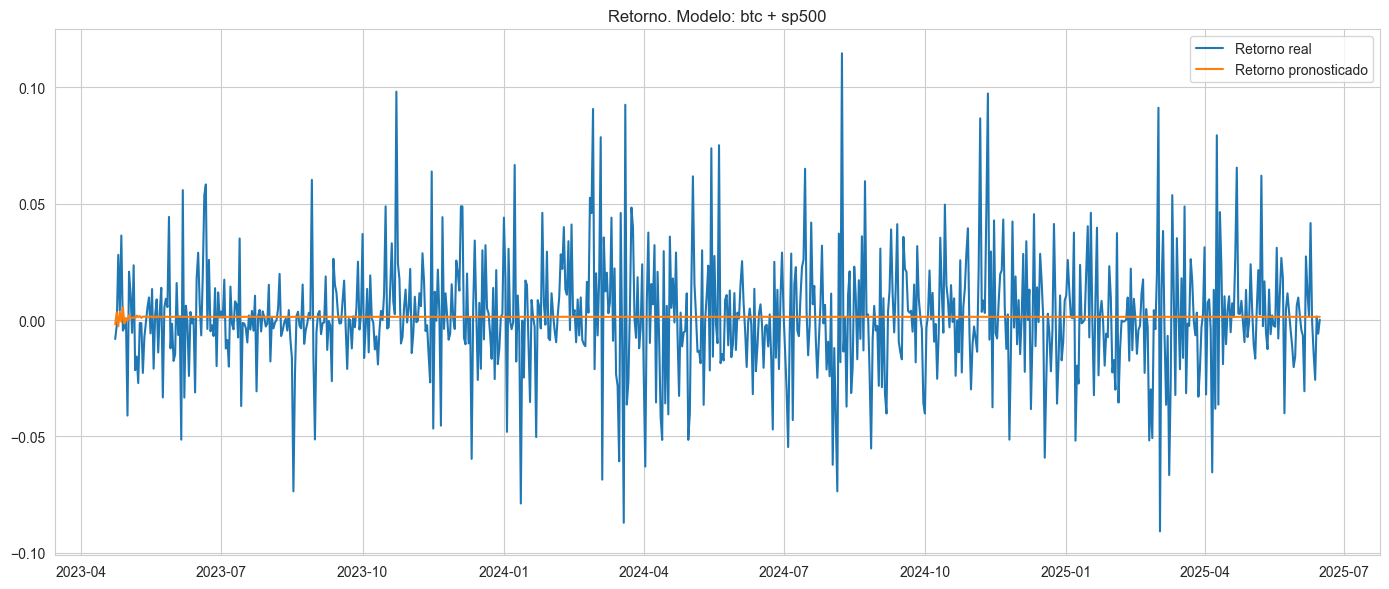

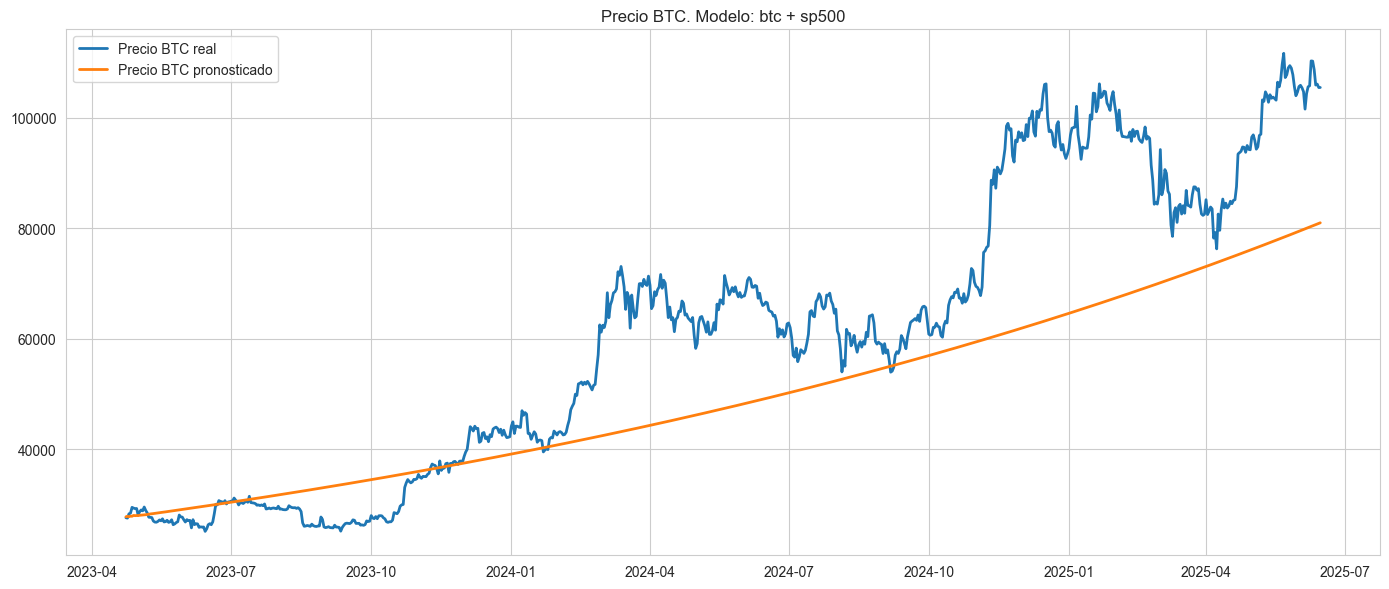

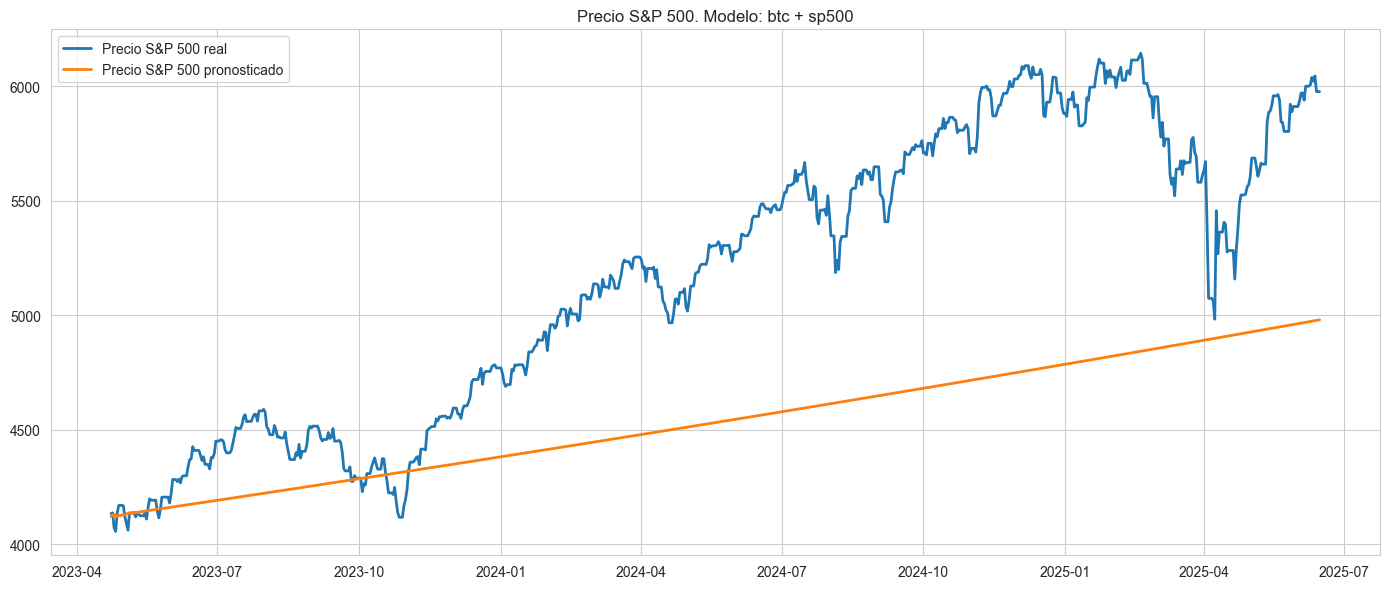


── btc + fear_greed ──
Entrenando VAR

Resumen del modelo:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Jun, 2025
Time:                     16:13:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.40996
Nobs:                     2149.00    HQIC:                  -3.44009
Log likelihood:          -2365.55    FPE:                  0.0315093
AIC:                     -3.45747    Det(Omega_mle):       0.0312471
--------------------------------------------------------------------
Results for equation btc_log_return
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.001956         0.001883           -1.038           0.299
L1.btc_log_return        -0.048724         0.021632         

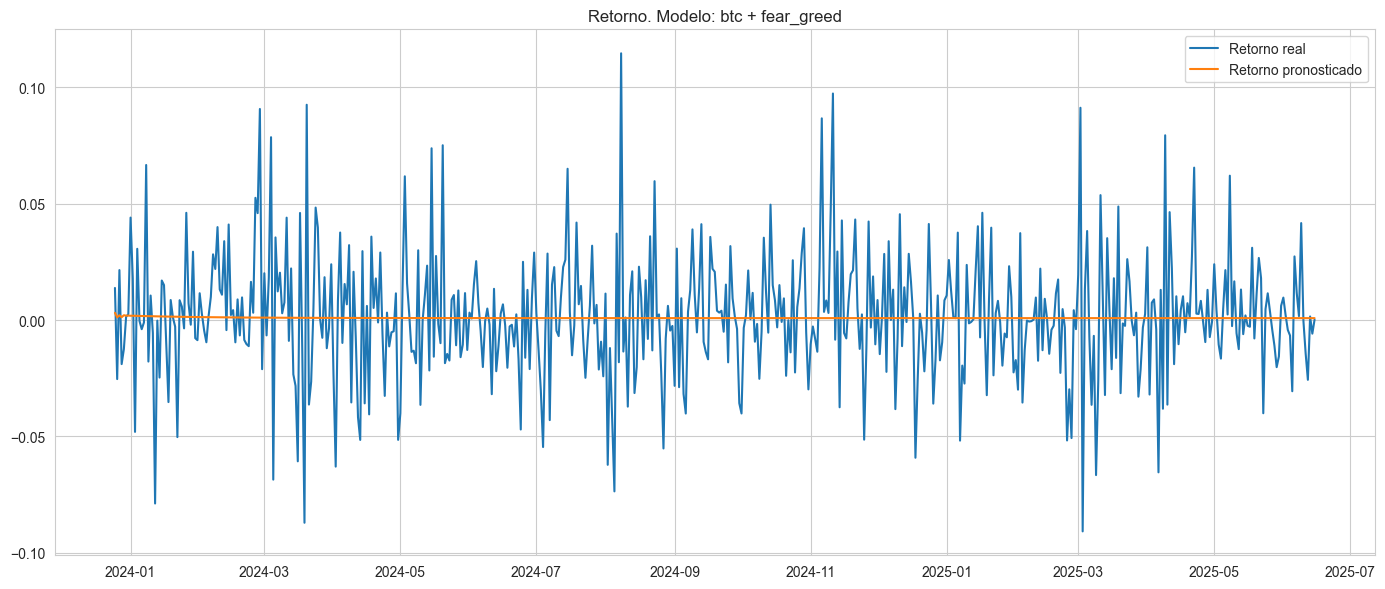

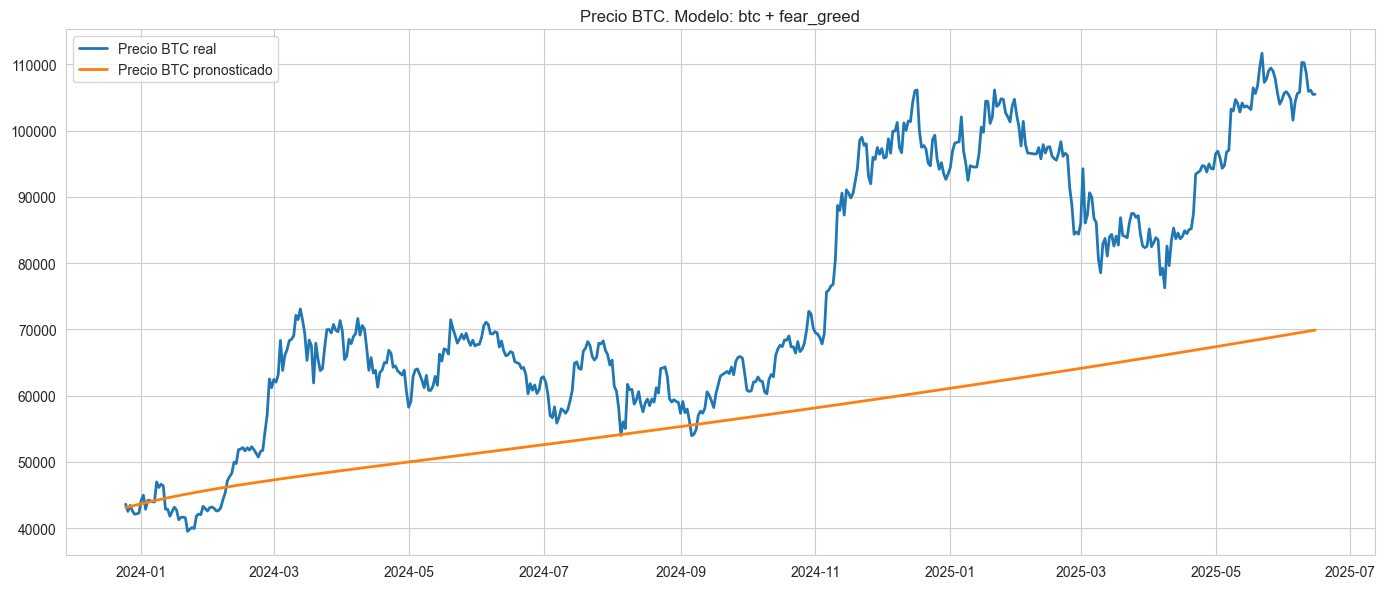


── btc + trend_diff ──
Entrenando VAR

Resumen del modelo:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Jun, 2025
Time:                     16:13:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.15317
Nobs:                     3118.00    HQIC:                  -3.26005
Log likelihood:          -3586.77    FPE:                  0.0361565
AIC:                     -3.31990    Det(Omega_mle):       0.0351795
--------------------------------------------------------------------
Results for equation btc_log_return
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.001217         0.000693            1.755           0.079
L1.btc_log_return         -0.020251         0.018015     

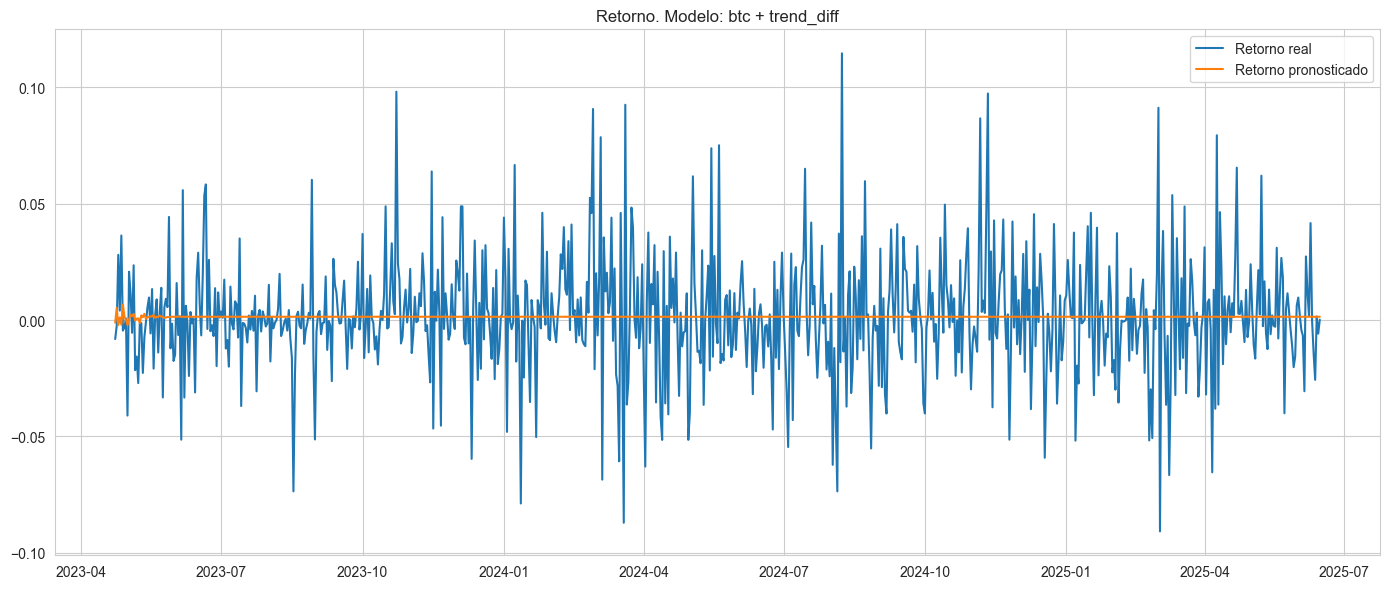

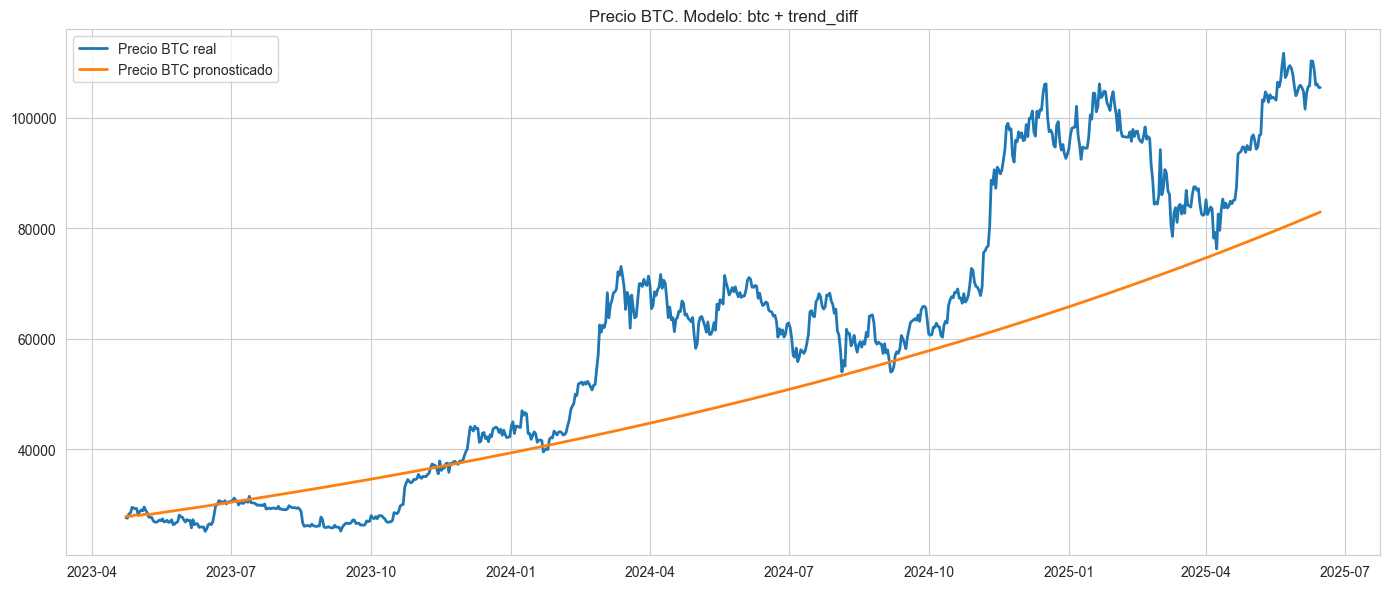


── btc + active_addresses ──
Entrenando VAR

Resumen del modelo:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Jun, 2025
Time:                     16:13:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.0651
Nobs:                     3111.00    HQIC:                  -12.2071
Log likelihood:           10397.1    FPE:                4.61338e-06
AIC:                     -12.2866    Det(Omega_mle):     4.44886e-06
--------------------------------------------------------------------
Results for equation btc_log_return
                                     coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------
const                                   0.001250         0.000838            1.491           0.136
L1.btc_log_r

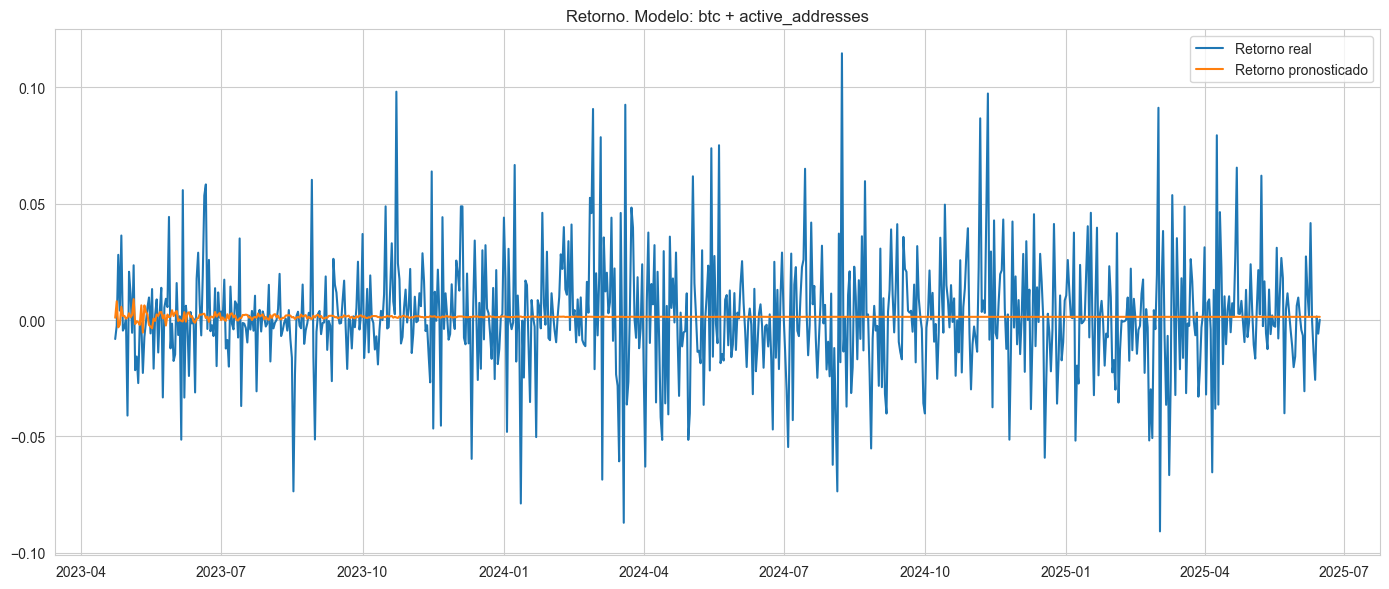

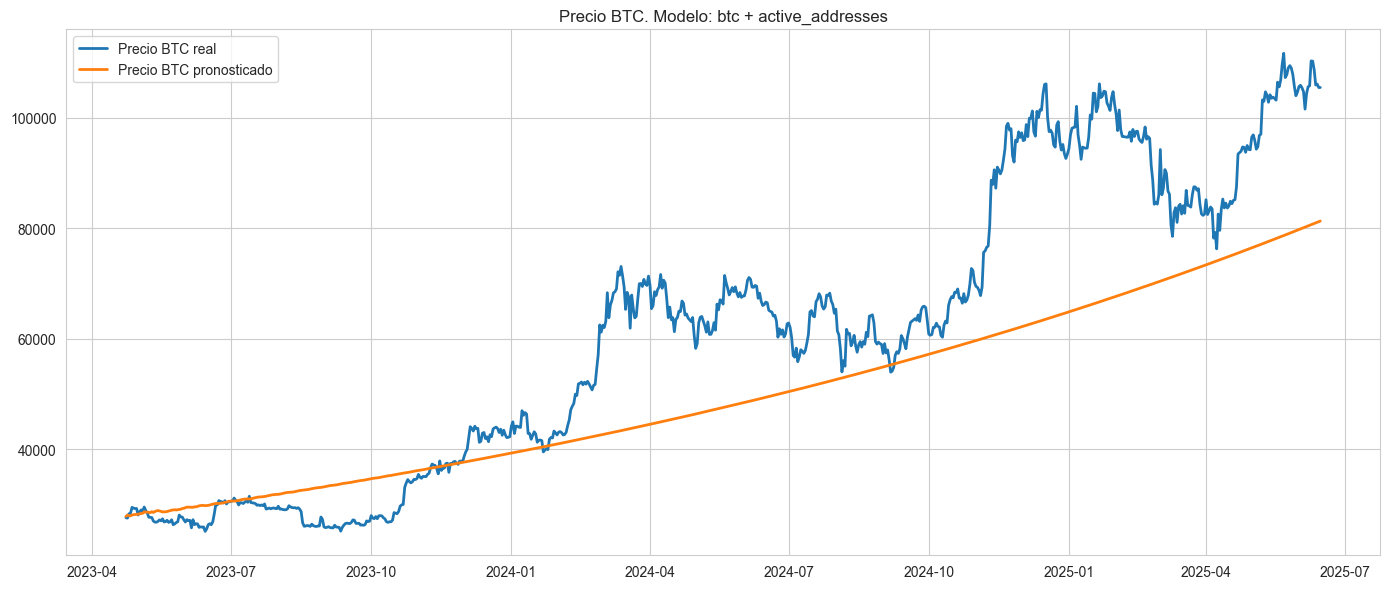


── btc + sp500 + gold ──
Entrenando VAR

Resumen del modelo:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Jun, 2025
Time:                     16:13:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -25.2838
Nobs:                     3123.00    HQIC:                  -25.4662
Log likelihood:           26778.0    FPE:                7.86690e-12
AIC:                     -25.5684    Det(Omega_mle):     7.50792e-12
--------------------------------------------------------------------
Results for equation btc_log_return
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.001280         0.000694            1.843           0.065
L1.btc_log_return           -0.016329         0.0

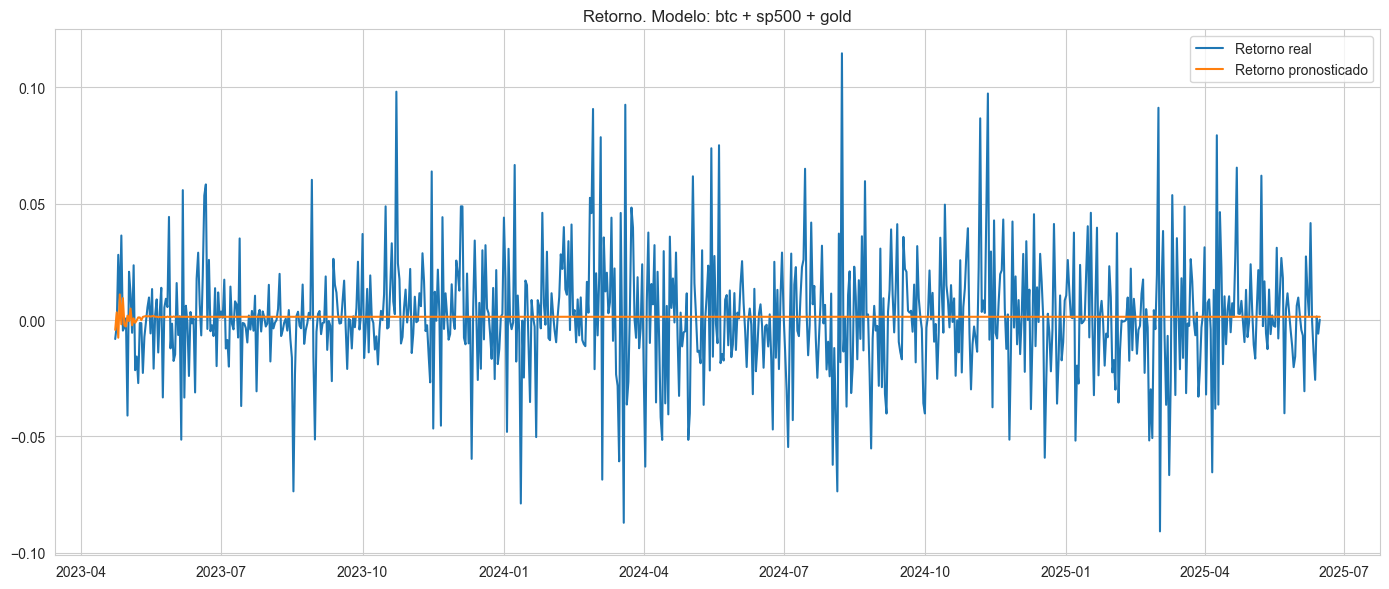

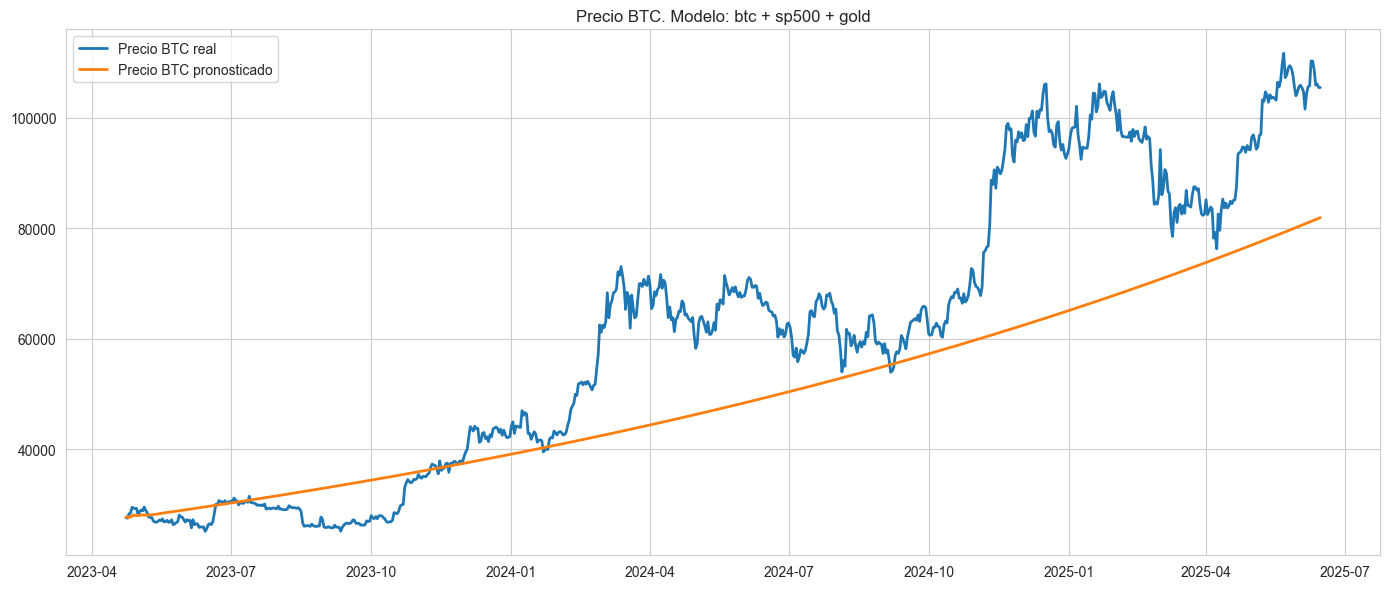

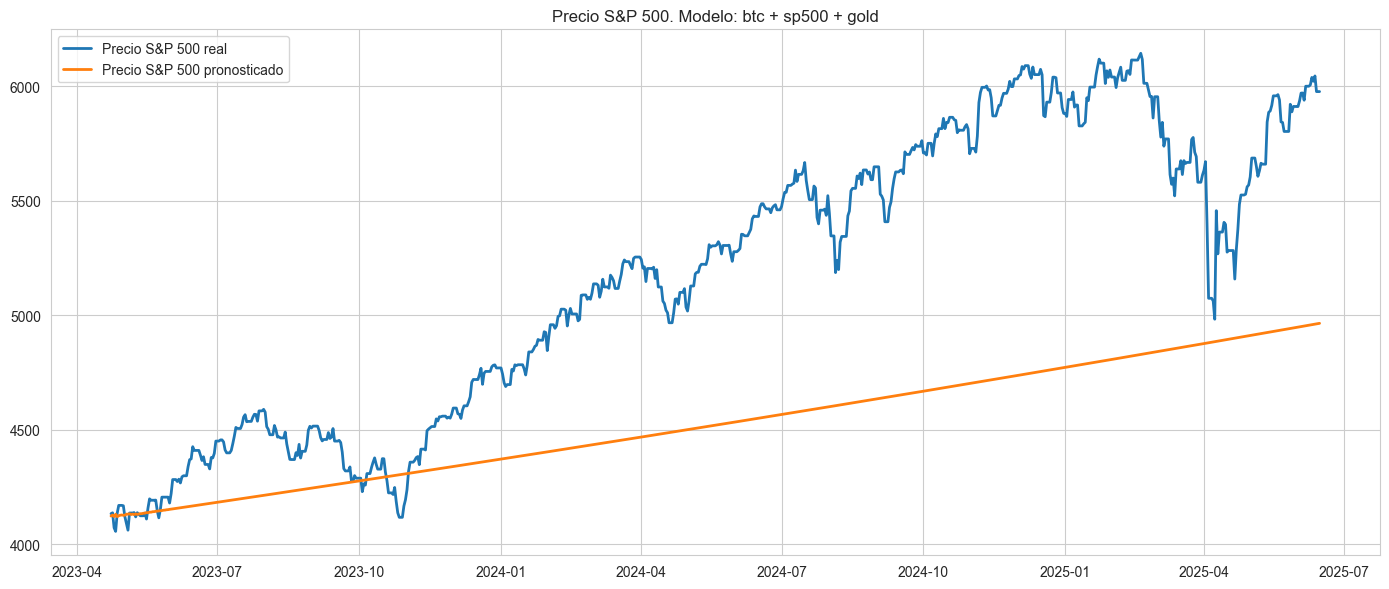


── btc + sp500 + fear_greed + trend_diff + active_addresses ──
Entrenando VAR

Resumen del modelo:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Jun, 2025
Time:                     16:13:27
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -13.7724
Nobs:                     2129.00    HQIC:                  -14.7927
Log likelihood:           1874.26    FPE:                2.08960e-07
AIC:                     -15.3817    Det(Omega_mle):     1.58500e-07
--------------------------------------------------------------------
Results for equation btc_log_return
                                     coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------
const                                  -0.003189         0.002502           -

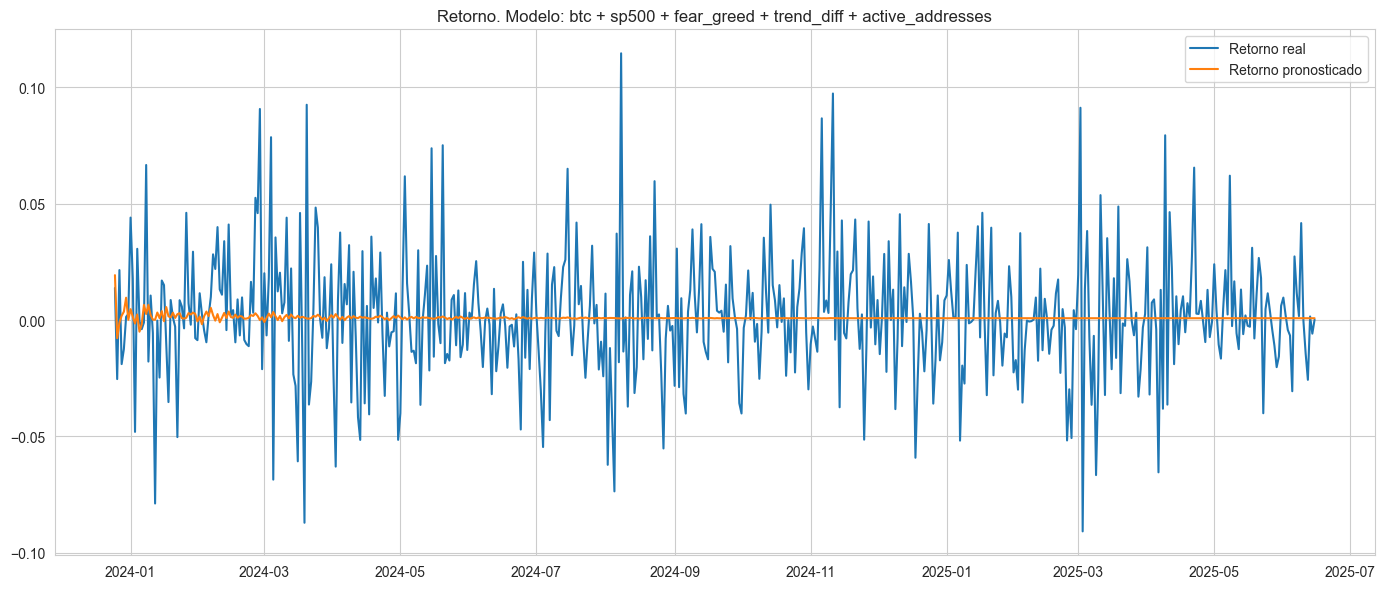

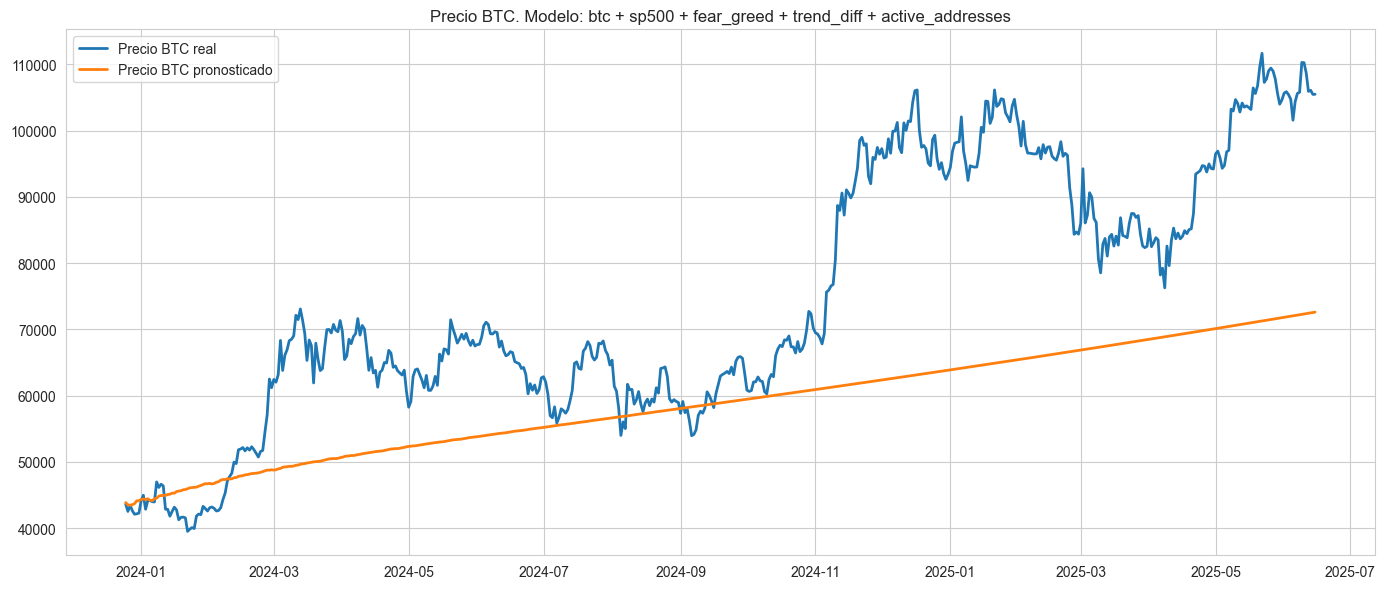

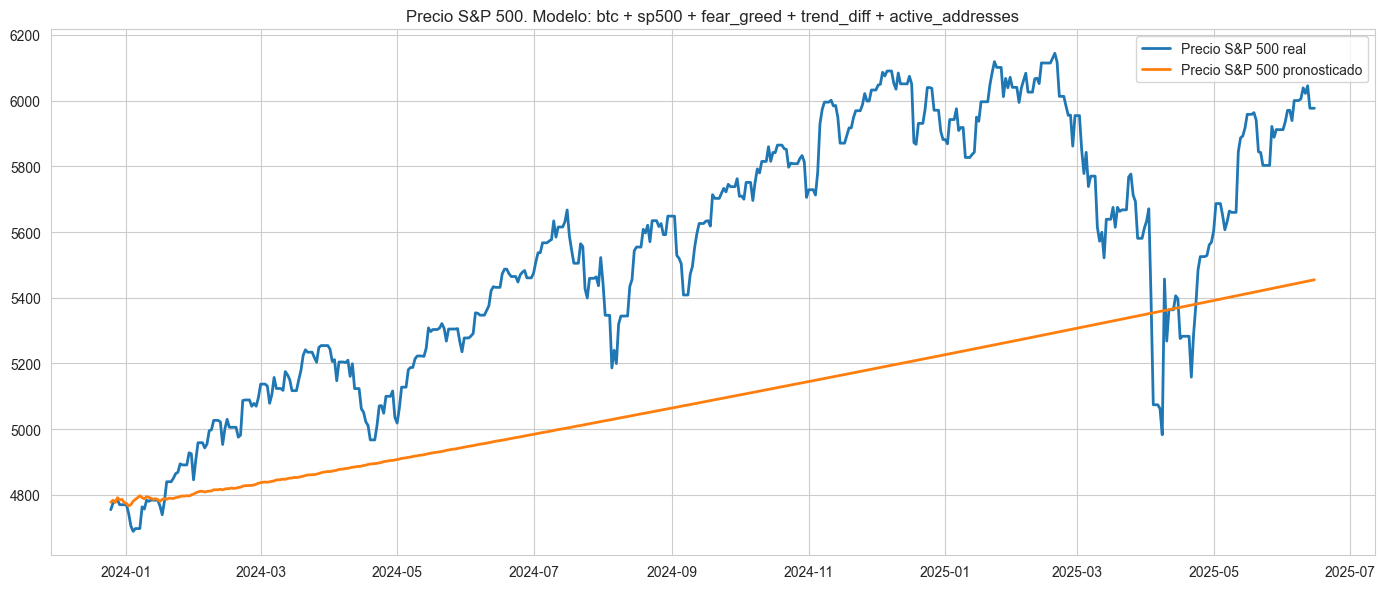


── btc + dxy + fear_greed (rsi exog) ──
Entrenando VARMAX

Resumen del modelo:
                                           Statespace Model Results                                           
Dep. Variable:     ['btc_log_return', 'dxy_log_return', 'fear_greed']   No. Observations:                 2153
Model:                                                    VARMAX(1,1)   Log Likelihood                6462.550
                                                          + intercept   AIC                         -12865.100
Date:                                                Mon, 16 Jun 2025   BIC                         -12694.862
Time:                                                        16:13:30   HQIC                        -12802.825
Sample:                                                    02-01-2018                                         
                                                         - 12-24-2023                                         
Covariance Type:                

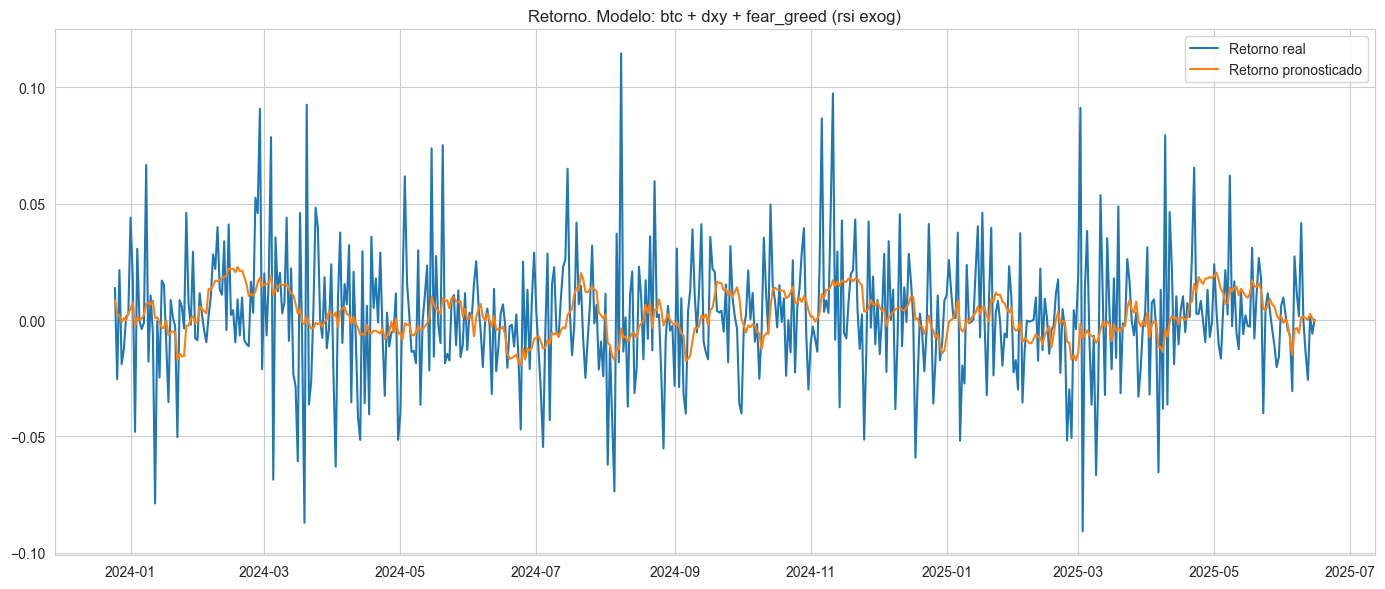

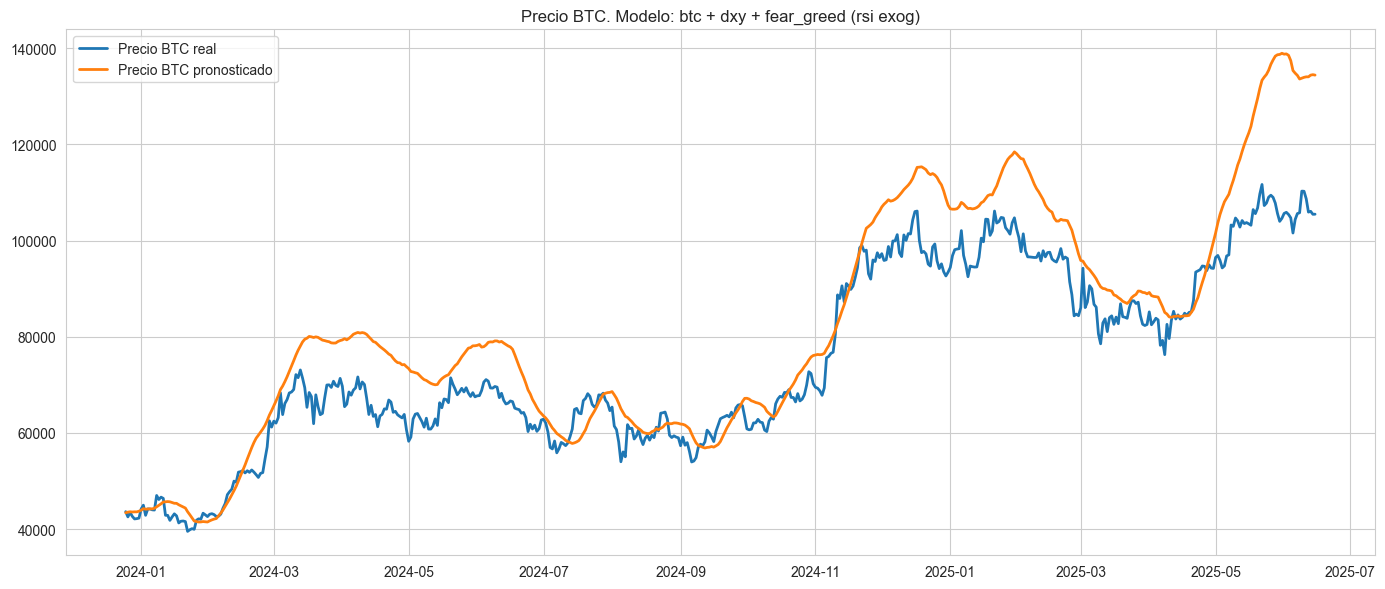


── btc + sp500 + gold (rsi exog) ──
Entrenando VARMAX

Resumen del modelo:
                                               Statespace Model Results                                              
Dep. Variable:     ['btc_log_return', 'sp500_log_return', 'gold_log_return']   No. Observations:                 3139
Model:                                                           VARMAX(1,1)   Log Likelihood               26881.176
                                                                 + intercept   AIC                         -53702.351
Date:                                                       Mon, 16 Jun 2025   BIC                         -53520.802
Time:                                                               16:13:34   HQIC                        -53637.199
Sample:                                                           09-18-2014                                         
                                                                - 04-22-2023                      

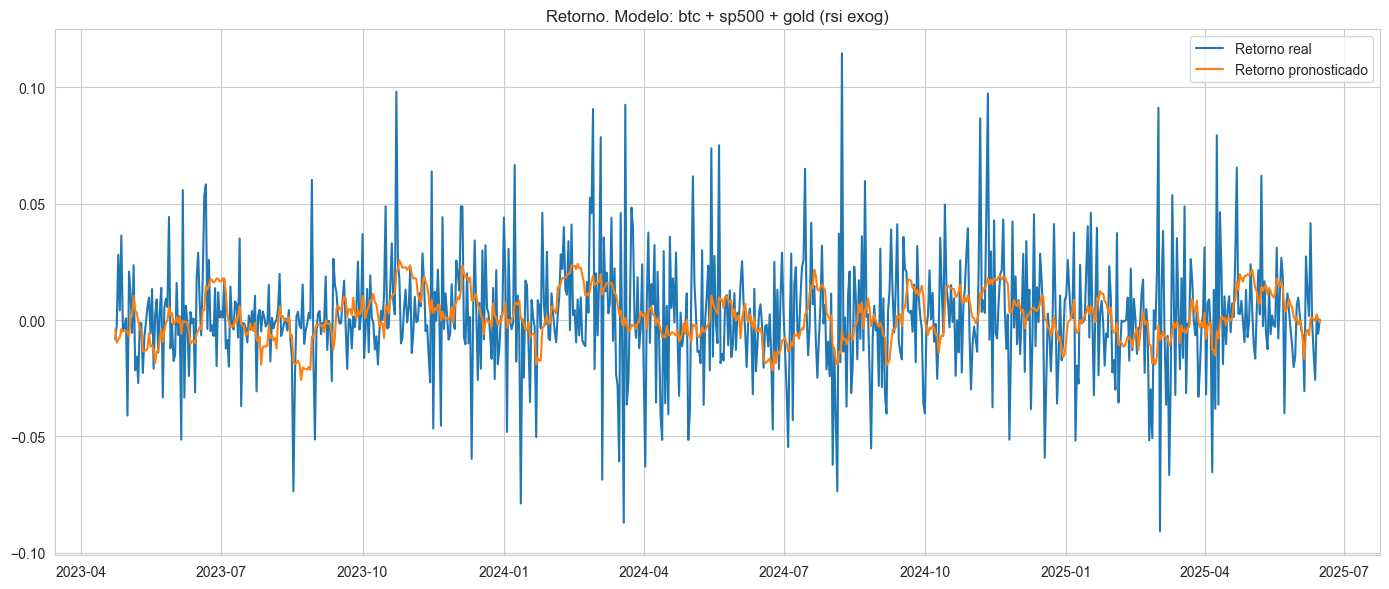

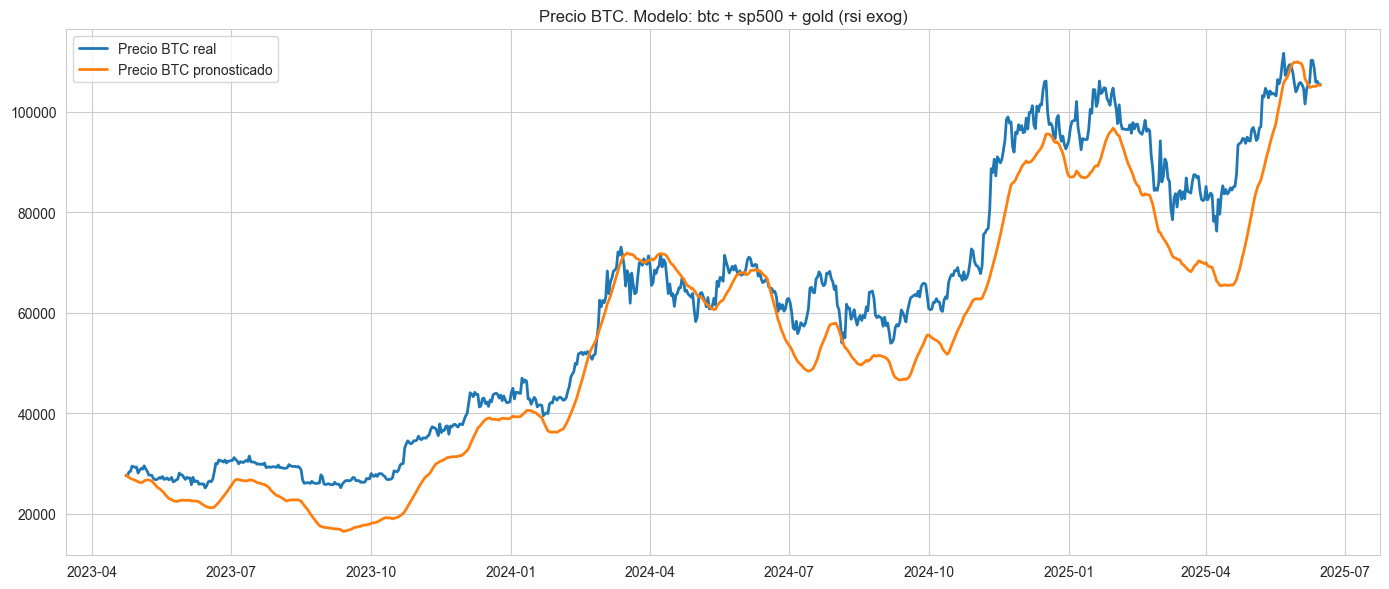

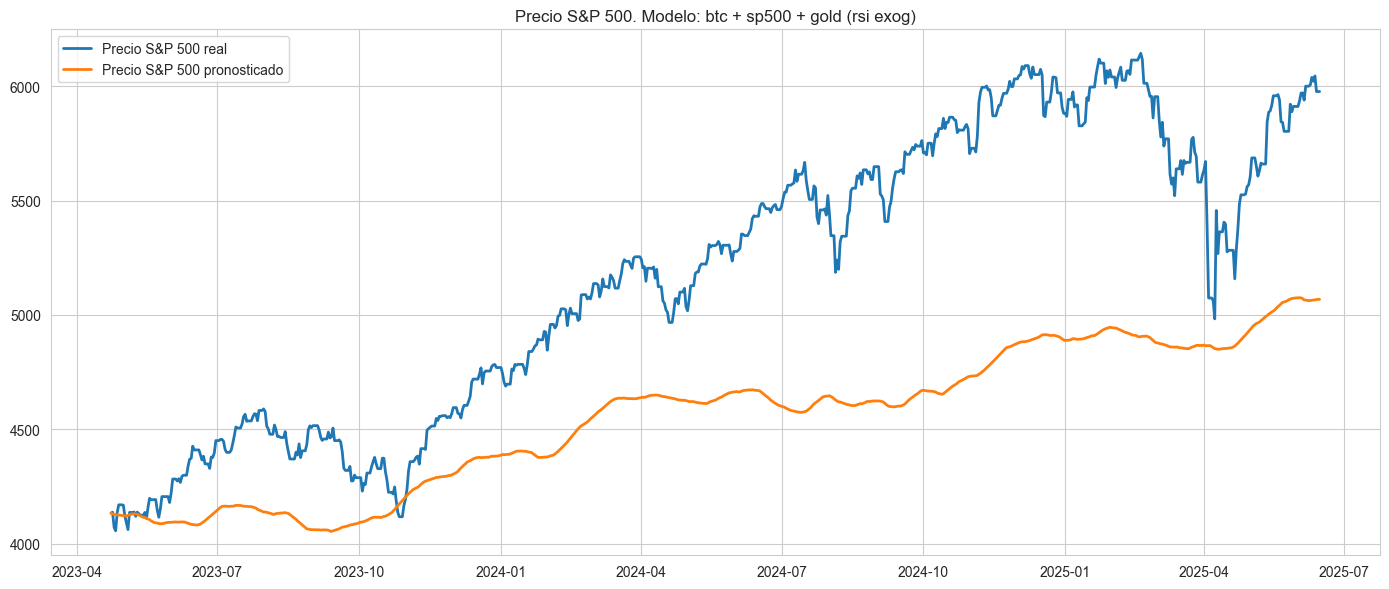


── btc + eth (rsi + interest exog) ──
Entrenando VARMAX

Resumen del modelo:
                                    Statespace Model Results                                    
Dep. Variable:     ['btc_log_return', 'eth_log_return']   No. Observations:                 2220
Model:                                      VARMAX(1,1)   Log Likelihood                8899.047
                                            + intercept   AIC                         -17764.094
Date:                                  Mon, 16 Jun 2025   BIC                         -17667.104
Time:                                          16:13:36   HQIC                        -17728.669
Sample:                                      11-10-2017                                         
                                           - 12-08-2023                                         
Covariance Type:                                    opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarq

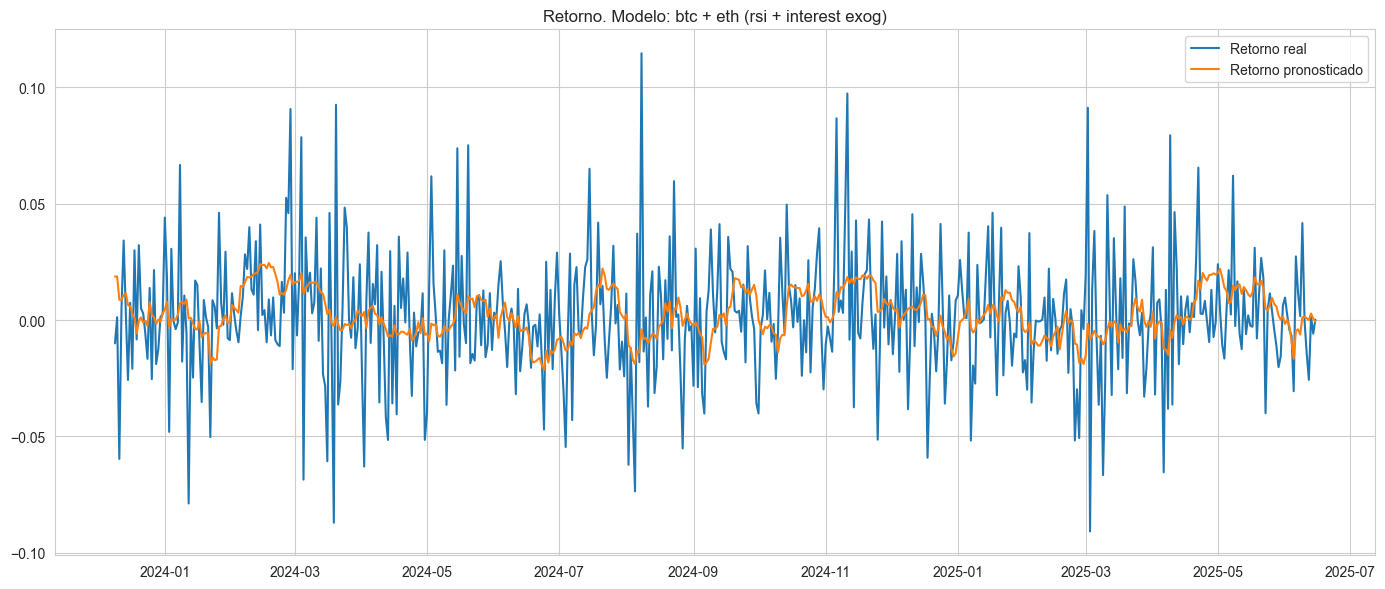

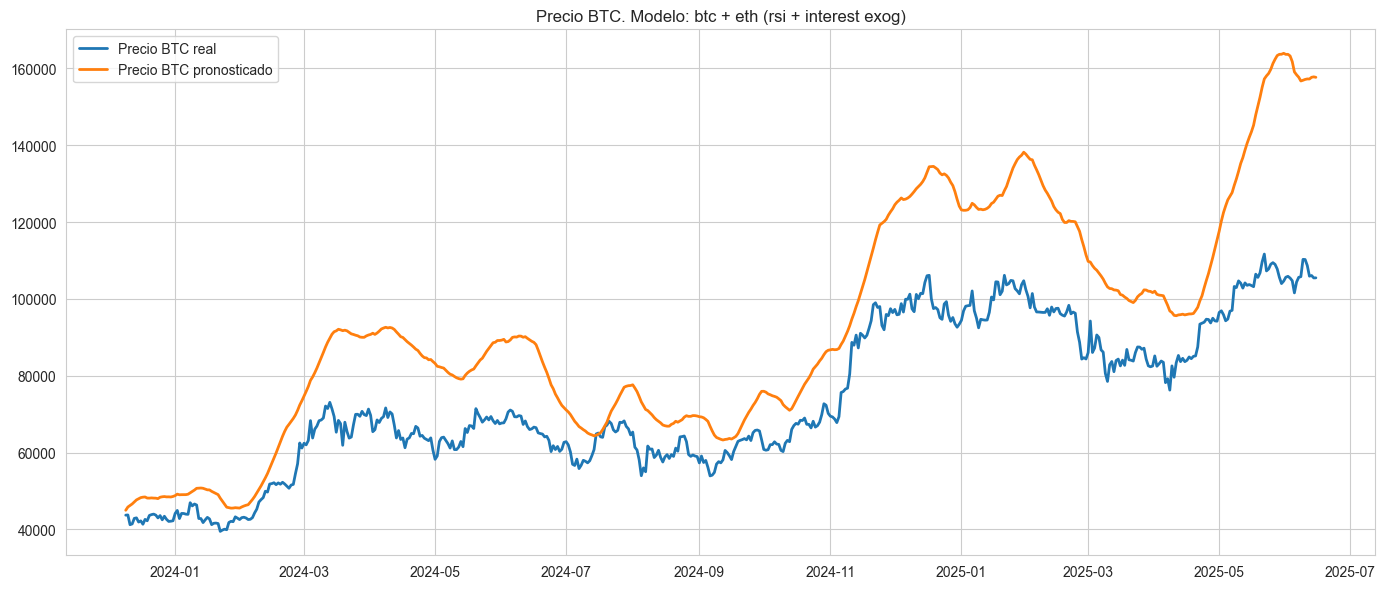


── btc + fear_greed + active (rsi + interest exog) ──
Entrenando VARMAX

Resumen del modelo:
                                            Statespace Model Results                                            
Dep. Variable:     ['btc_log_return', 'fear_greed', 'active_addresses']   No. Observations:                 2153
Model:                                                      VARMAX(1,1)   Log Likelihood              -28855.550
                                                            + intercept   AIC                          57777.099
Date:                                                  Mon, 16 Jun 2025   BIC                          57964.362
Time:                                                          16:13:41   HQIC                         57845.602
Sample:                                                      02-01-2018                                         
                                                           - 12-24-2023                                         
Co

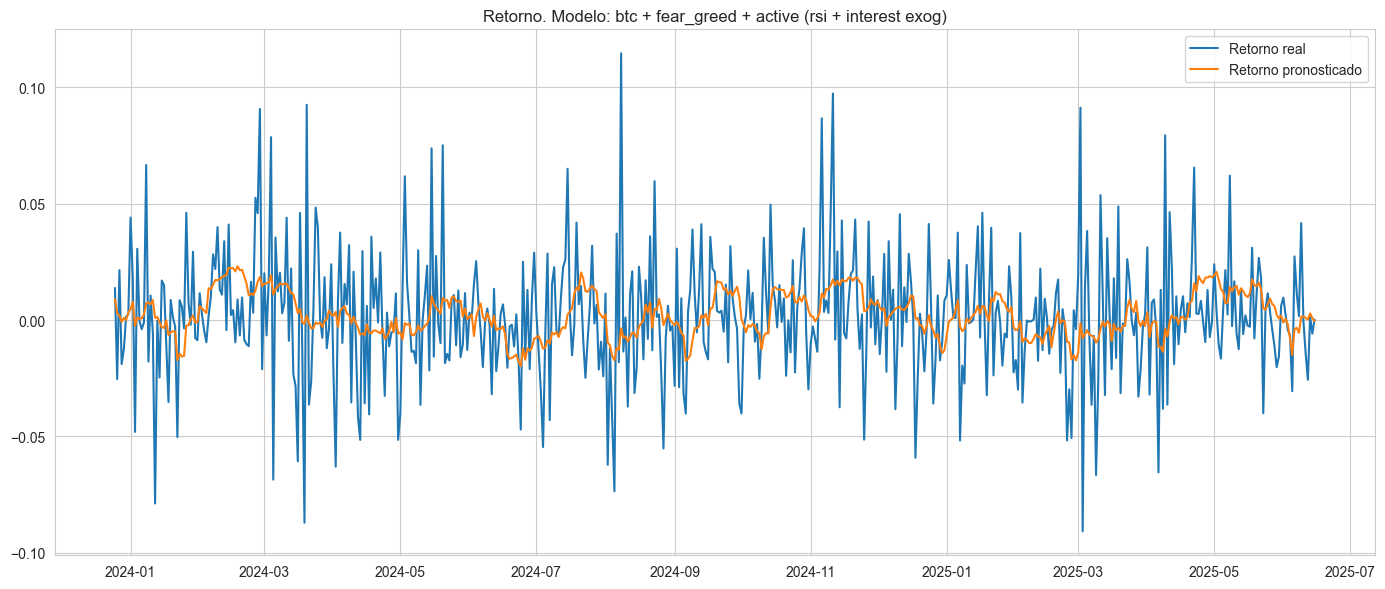

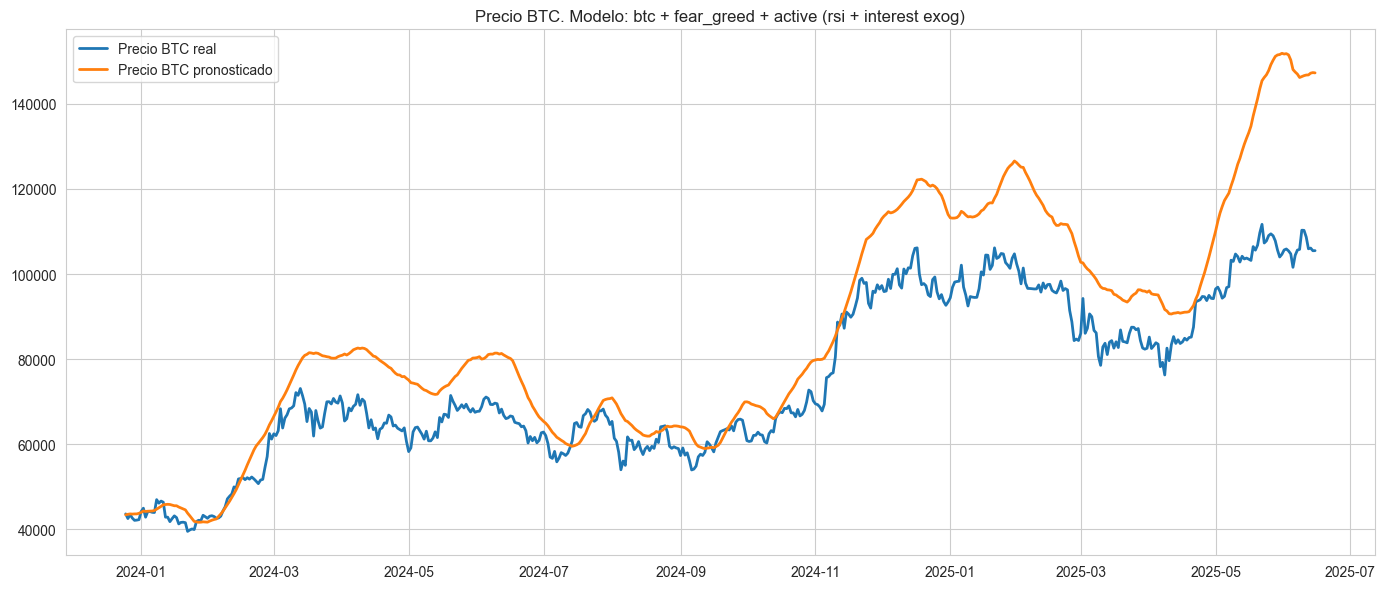


── btc + todos salvo RSI (rsi + interest exog) ──
Entrenando VARMAX

Resumen del modelo:
                                                                                              Statespace Model Results                                                                                              
Dep. Variable:     ['btc_log_return', 'sp500_log_return', 'gold_log_return', 'dxy_log_return', 'eth_log_return', 'fear_greed', 'trend_diff', 'active_addresses_pct_change']   No. Observations:                 2153
Model:                                                                                                                                                          VARMAX(1,1)   Log Likelihood               21704.413
                                                                                                                                                                + intercept   AIC                         -43032.826
Date:                                                     

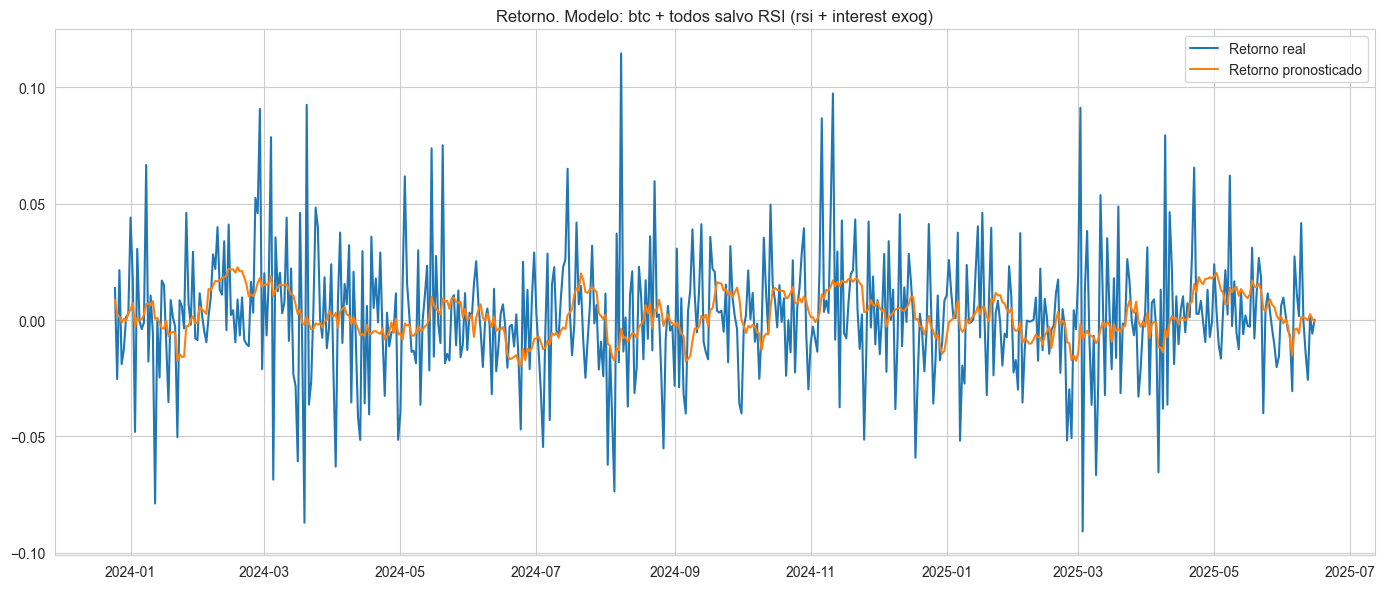

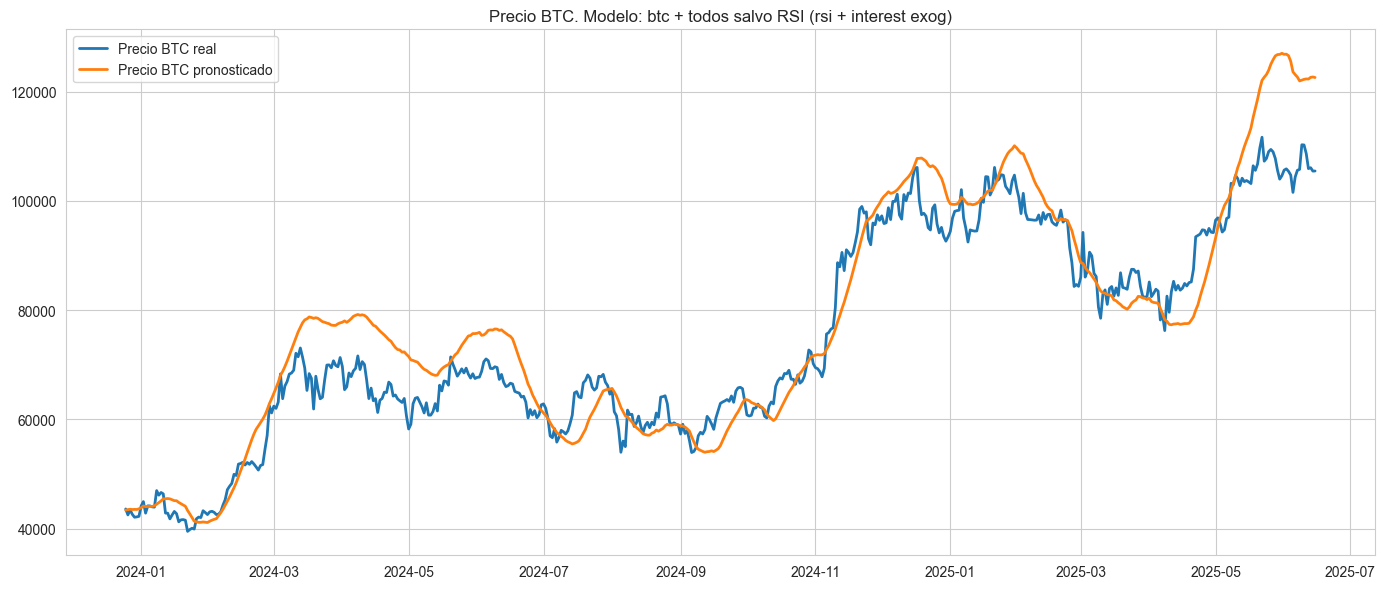

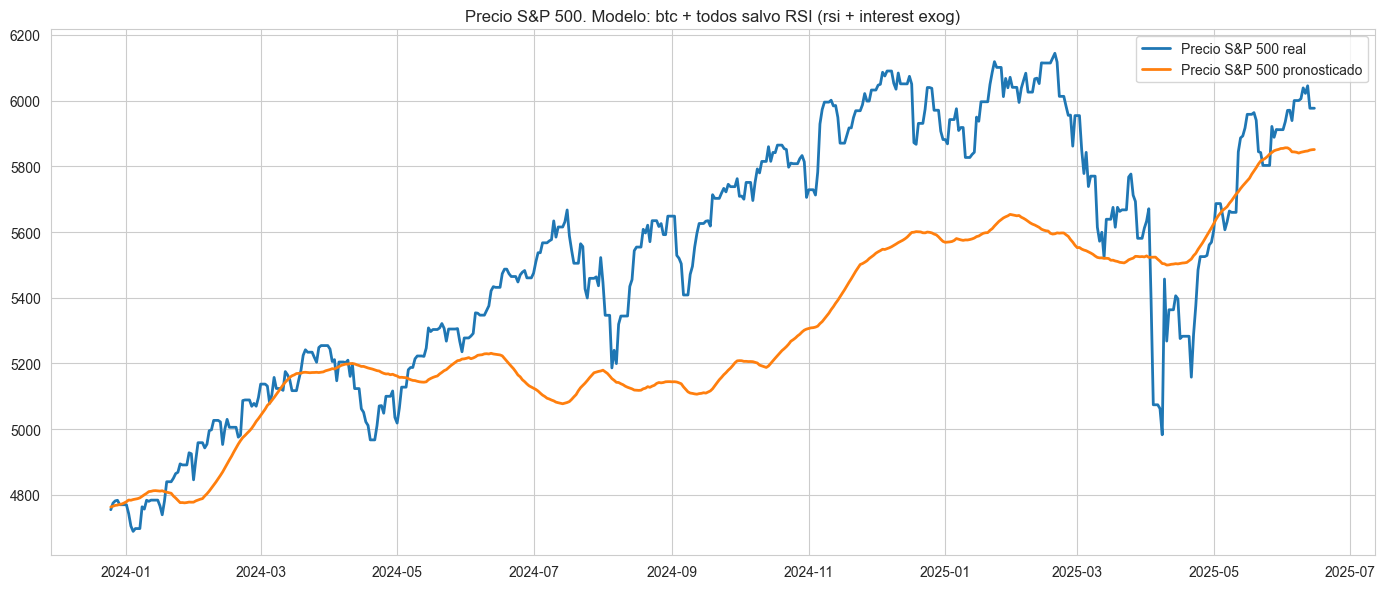


── btc + trend (rsi + interest exog) ──
Entrenando VARMAX

Resumen del modelo:
                                  Statespace Model Results                                  
Dep. Variable:     ['btc_log_return', 'trend_diff']   No. Observations:                 3139
Model:                                  VARMAX(1,1)   Log Likelihood               -3717.238
                                        + intercept   AIC                           7468.475
Date:                              Mon, 16 Jun 2025   BIC                           7571.354
Time:                                      16:14:39   HQIC                          7505.395
Sample:                                  09-18-2014                                         
                                       - 04-22-2023                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarque-Bera (JB):   14081.27, 875311.6

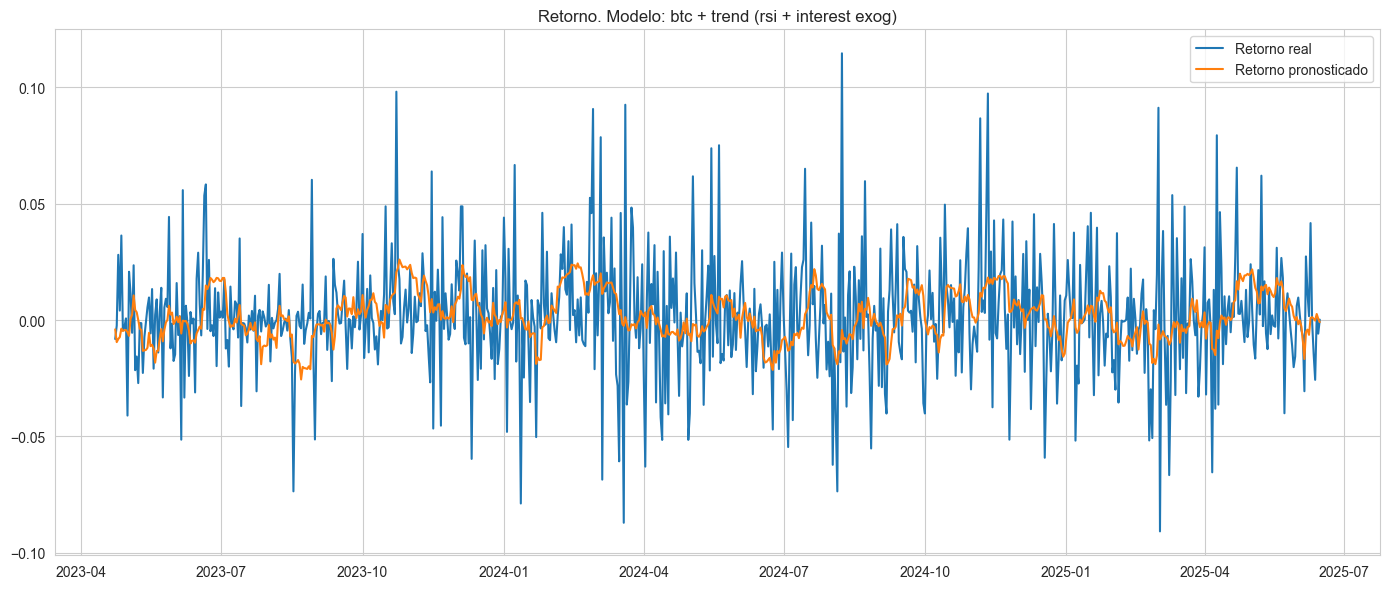

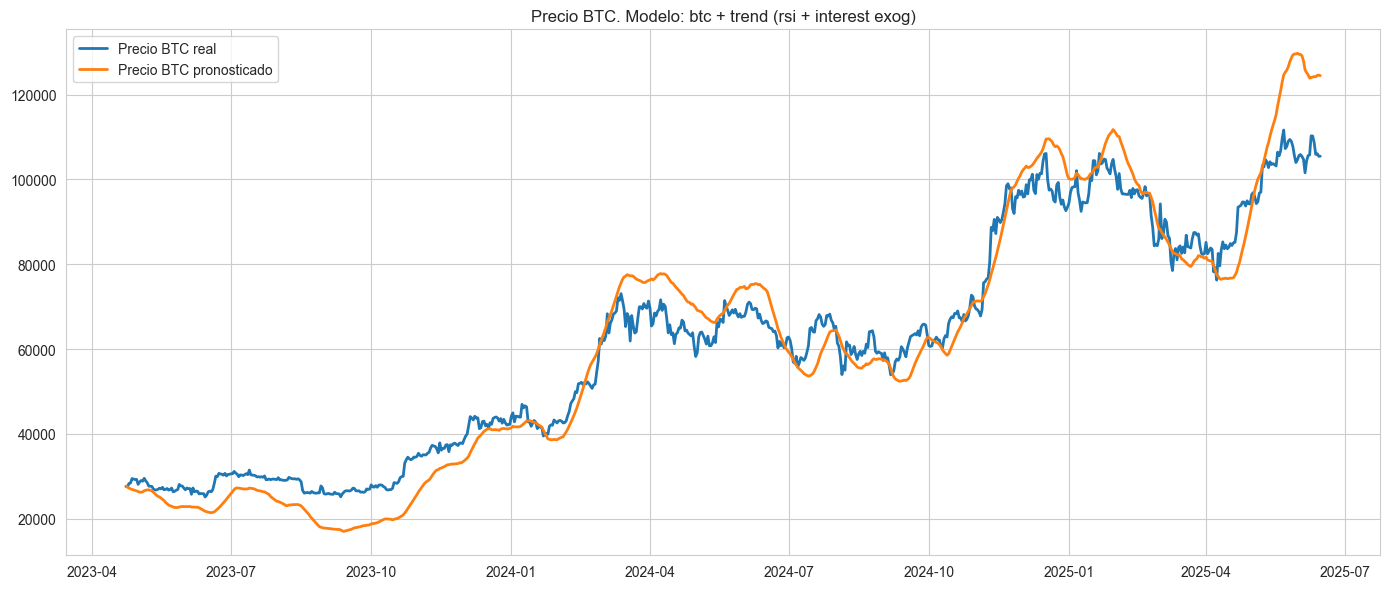


── btc + sp500 (todo exog) ──
Entrenando VARMAX

Resumen del modelo:
                                     Statespace Model Results                                     
Dep. Variable:     ['btc_log_return', 'sp500_log_return']   No. Observations:                 2153
Model:                                        VARMAX(1,1)   Log Likelihood               12222.086
                                              + intercept   AIC                         -24386.173
Date:                                    Mon, 16 Jun 2025   BIC                         -24221.609
Time:                                            16:14:40   HQIC                        -24325.973
Sample:                                        02-01-2018                                         
                                             - 12-24-2023                                         
Covariance Type:                                      opg                                         
Ljung-Box (L1) (Q):             0.17, 0

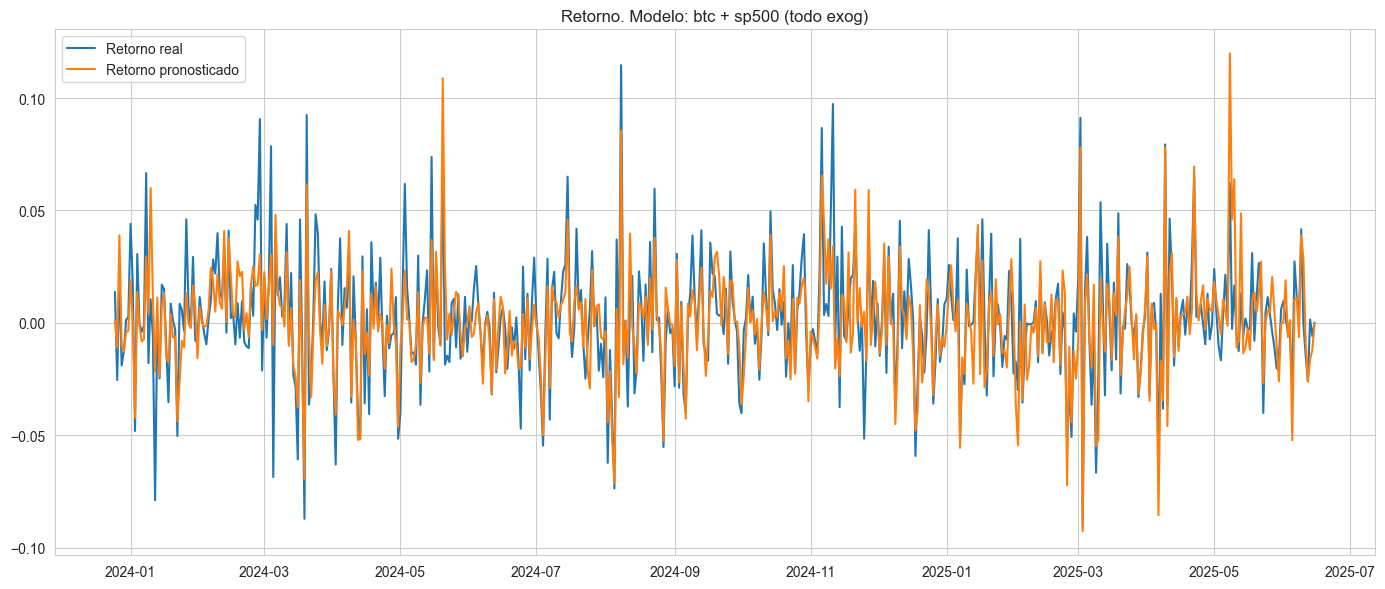

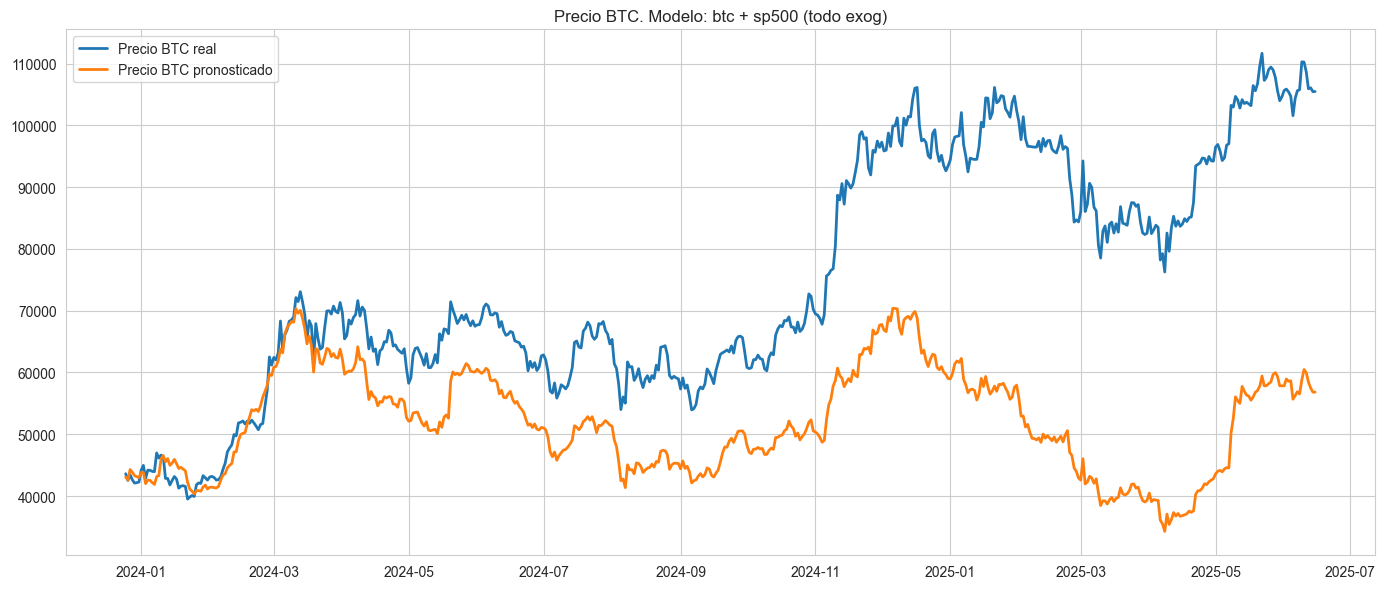

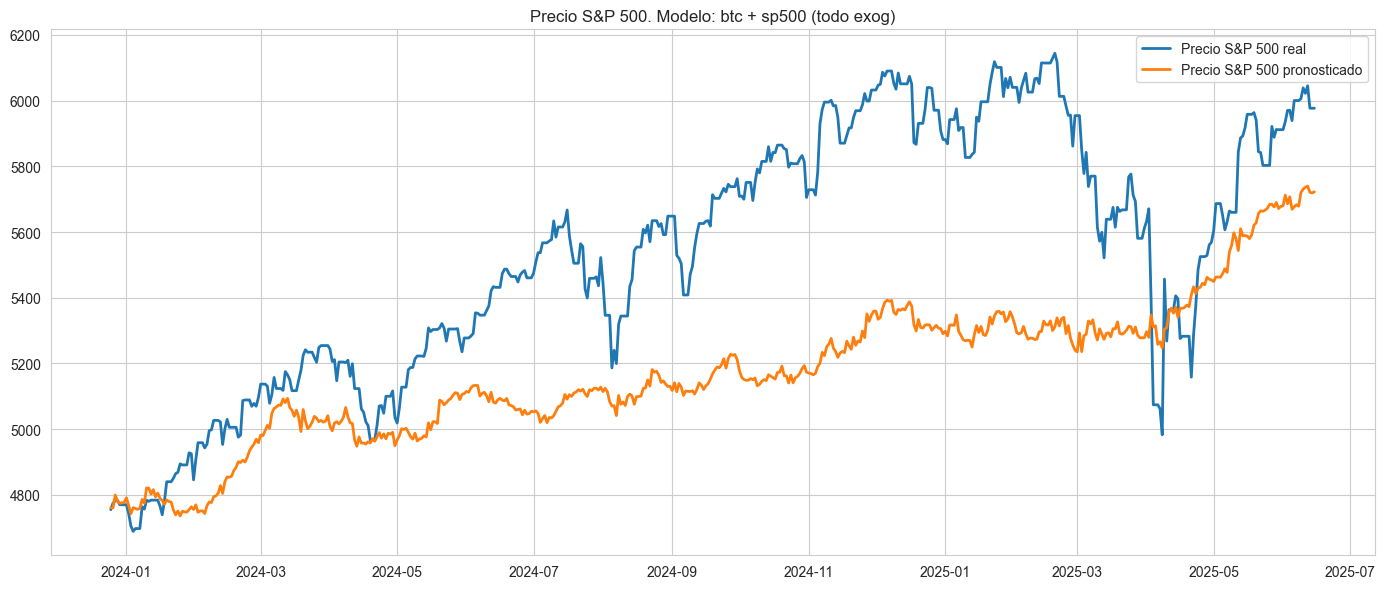

In [67]:
results   = []
output_dir = Path("../models")
output_dir.mkdir(parents=True, exist_ok=True)

for name, vars_ in models.items():
    print(f"\n── {name} ──")
    endog = vars_["endog"]
    exog  = vars_["exog"]

    # 1) Ventanas
    Y, X = load_window(df, endog, exog)
    Y_tr, Y_te, X_tr, X_te = split_train_test(Y, X, split=0.80)

    # 2) Entrenar y guardar
    model = fit_model(Y_tr, X_tr)
    model_path = output_dir / f"{name.replace(' + ', '_')}.pkl"
    with open(model_path, "wb") as f:
        pickle.dump(model, f)

    # 3) Pronóstico
    F = forecast_var_varmax(model, Y_tr, Y_te, X_te)

    # 4) Retornos y precio BTC
    plot_returns(Y_te["btc_log_return"], F["btc_log_return"], model_name=name)
    plot_price(
        Y_te["btc_log_return"],
        F["btc_log_return"],
        df["btc_close"],
        model_name=name,
        price_label="Precio BTC"
    )

    # 5) Retornos y precio S&P 500 SOLO si es endógena
    if "sp500_log_return" in Y_te.columns:
        plot_price(
            Y_te["sp500_log_return"],
            F["sp500_log_return"],
            df["sp500_close"],
            model_name=name,
            price_label="Precio S&P 500"
        )

    # 6) Métricas y log
    p0_btc   = df["btc_close"].loc[Y_te.index[0] - pd.Timedelta(days=1)]
    btc_real = reconstruct_price(Y_te["btc_log_return"], p0_btc)
    btc_pred = reconstruct_price(F["btc_log_return"],  p0_btc)

    metrics = price_metrics(btc_real, btc_pred)
    results.append({
        "modelo": name,
        "aic": model.aic,
        "bic": model.bic,
        **metrics
    })

In [69]:
# Convertir a DataFrame y ordenar
chart = pd.DataFrame(results)
chart = chart.rename(columns={"MAE": "mae_price", "RMSE": "rmse_price"})
chart = chart[["modelo", "aic", "bic", "mae_price", "rmse_price"]]
ordered_chart = chart.sort_values(by="rmse_price")

# Mostrar en Markdown
print("\n📊 Comparación de modelos (formato Markdown):\n")
print(tabulate(ordered_chart, headers="keys", tablefmt="github", showindex=False))



📊 Comparación de modelos (formato Markdown):

| modelo                                                   |          aic |          bic |   mae_price |   rmse_price |
|----------------------------------------------------------|--------------|--------------|-------------|--------------|
| btc + todos salvo RSI (rsi + interest exog)              | -43032.8     | -41966       |     5168.86 |      6793.85 |
| btc + trend (rsi + interest exog)                        |   7468.48    |   7571.35    |     5463.87 |      6821.71 |
| btc + sp500 + gold (rsi exog)                            | -53702.4     | -53520.8     |     7238.19 |      8627.49 |
| btc + dxy + fear_greed (rsi exog)                        | -12865.1     | -12694.9     |     7700.69 |     10323.7  |
| btc + fear_greed + active (rsi + interest exog)          |  57777.1     |  57964.4     |    11418.6  |     15013.4  |
| btc + trend_diff                                         |     -3.3199  |     -3.15317 |    12342.8  |     1634